# CNN

Nipun Batra  
2023-04-03

<figure>
<a
href="https://colab.research.google.com/github/nipunbatra/ml-teaching/blob/master/notebooks/cnn.ipynb"><img
src="https://colab.research.google.com/assets/colab-badge.svg" /></a>
<figcaption>Open In Colab</figcaption>
</figure>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set random seed for reproducibility
torch.manual_seed(0)

# Torch version
torch.__version__

'2.0.0+cu118'

In [3]:
# MNIST dataset

from torchvision import datasets, transforms
import torchvision

# Split MNIST into train, validation, and test sets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

# Split train_data into train and validation sets
val_data = torch.utils.data.Subset(train_data, range(50000, 51000))

# Reduce the size of the training set to 5,000
train_data = torch.utils.data.Subset(train_data, range(0, 5000))


In [4]:
# Create data loaders
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [5]:
img, target = next(iter(train_loader))
print(img.shape)
print(target.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])

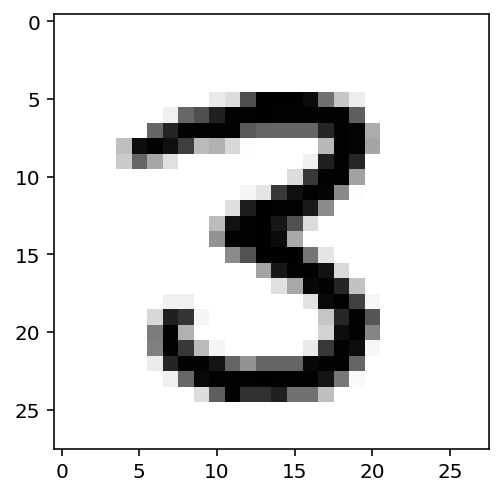

In [6]:
plt.imshow(img[0].numpy().squeeze(), cmap='gray_r');

In [7]:
img[0].shape

torch.Size([1, 28, 28])

In [8]:
# Create a simple LeNet like CNN

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(1, 6, 5) 
        # 6 input image channel, 16 output channels, 5x5 square convolution
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x) # 28x28x1 -> 24x24x6
        x = F.max_pool2d(F.relu(x), 2) # 24x24x6 -> 12x12x6
        x = self.conv2(x) # 12x12x6 -> 8x8x16
        x = F.max_pool2d(F.relu(x), 2) # 8x8x16 -> 4x4x16
        x = x.view(-1, self.num_flat_features(x)) # 4x4x16 -> 256
        x = self.fc1(x) # 256 -> 120
        x = F.relu(x)
        x = self.fc2(x) # 120 -> 84
        x = F.relu(x)
        x = self.fc3(x) # 84 -> 10
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [9]:
# Create a model

model = LeNet5()
print(model)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [10]:
# Train the model

# Define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
n_epochs = 10

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    # Train the model
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    # Evaluate the model
    model.eval()
    for data, target in val_loader:
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()*data.size(0)
        
    # Calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    val_loss = val_loss/len(val_loader.sampler)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        val_loss
        ))

Epoch: 1    Training Loss: 1.437300     Validation Loss: 0.653900
Epoch: 2    Training Loss: 0.424091     Validation Loss: 0.367598
Epoch: 3    Training Loss: 0.303504     Validation Loss: 0.308797
Epoch: 4    Training Loss: 0.219186     Validation Loss: 0.257062
Epoch: 5    Training Loss: 0.195089     Validation Loss: 0.214157
Epoch: 6    Training Loss: 0.153489     Validation Loss: 0.190220
Epoch: 7    Training Loss: 0.130065     Validation Loss: 0.189110
Epoch: 8    Training Loss: 0.114033     Validation Loss: 0.173153
Epoch: 9    Training Loss: 0.103402     Validation Loss: 0.167645
Epoch: 10   Training Loss: 0.089715     Validation Loss: 0.156438

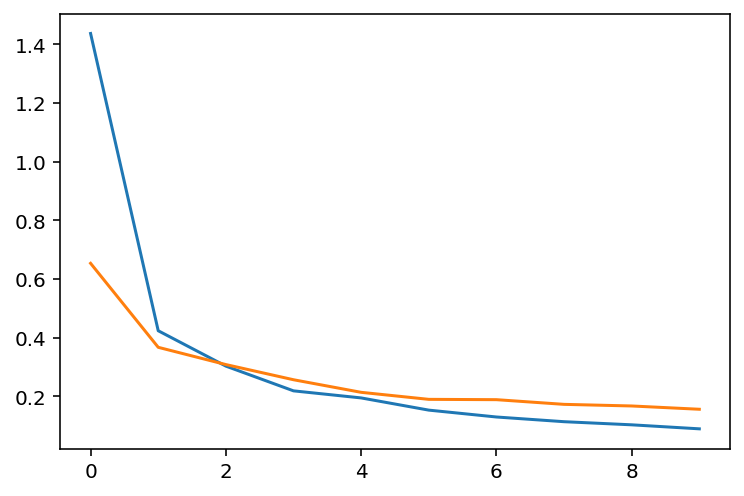

In [11]:
# Plot the training and validation loss

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')

In [12]:
# Test the model

with torch.no_grad():
    correct = 0
    total = 0
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    print('Test Accuracy: {}%'.format(100 * correct / total))

Test Accuracy: 96.1%

In [13]:
# Now, let us take an image and walk it through the model

test_img = train_data[1][0].unsqueeze(0)


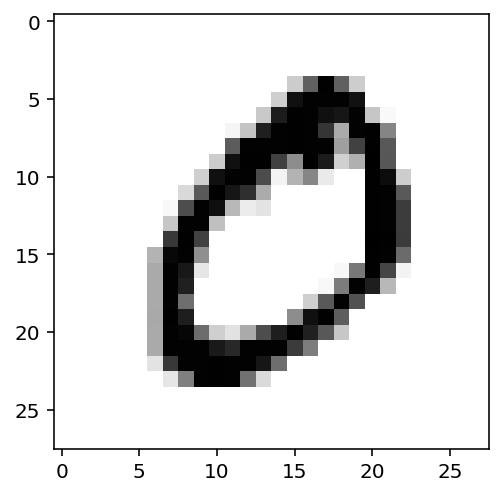

In [14]:
plt.imshow(test_img.numpy().squeeze(), cmap='gray_r');

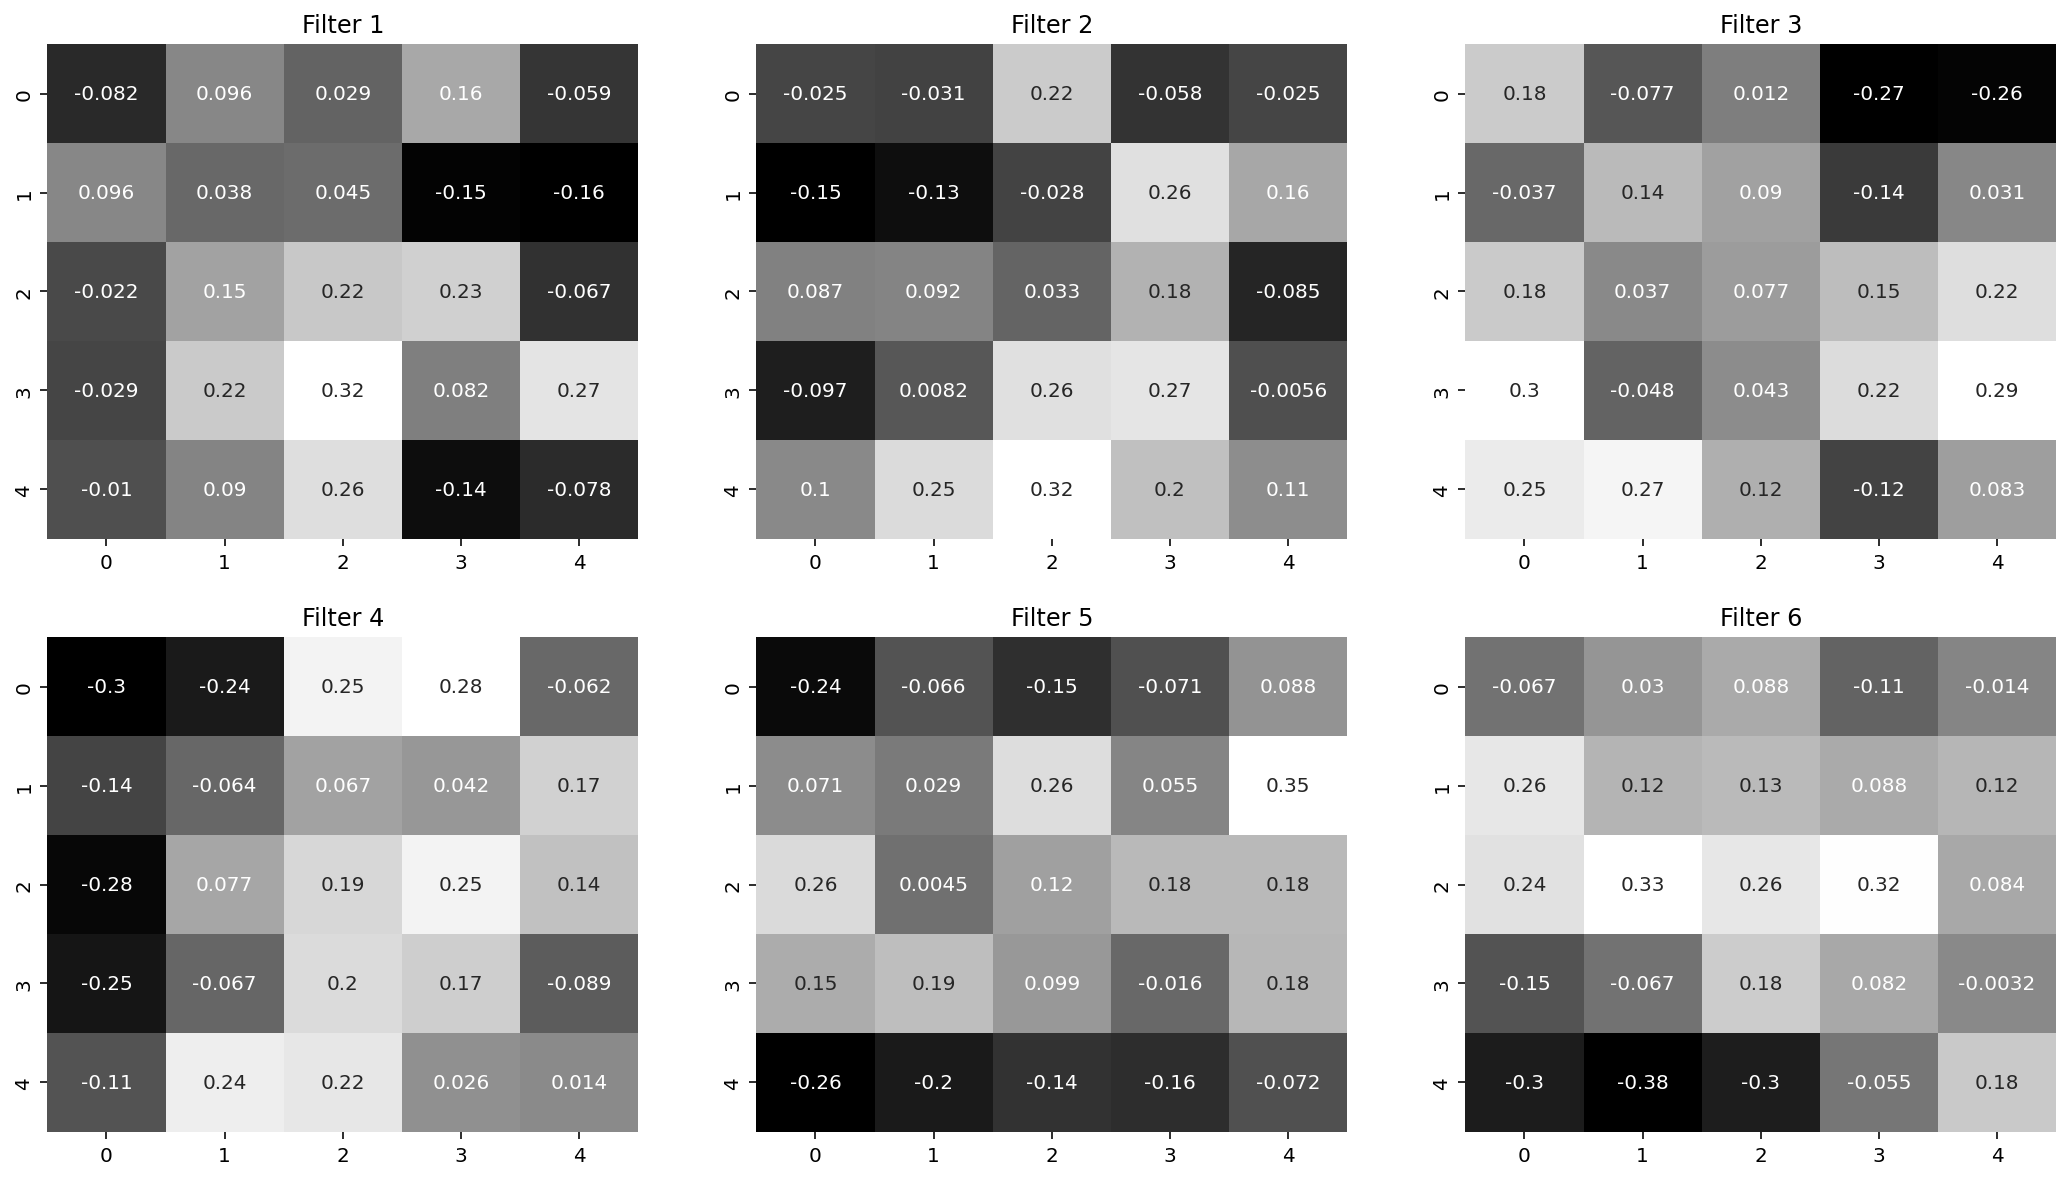

In [15]:
# Get weights and biases from the first convolutional layer

weights = model.conv1.weight.data
w = weights.numpy()

# Plot the weights

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
ax = axes.ravel()

for i in range(6):
    sns.heatmap(w[i][0], ax=ax[i], cmap='gray', cbar=False, annot=True)
    ax[i].set_title('Filter {}'.format(i+1))

In [16]:
# Get output from model's first conv1 layer

conv1 = F.relu(model.conv1(test_img))

# For plotting bring all the images to the same scale
c1 = conv1 - conv1.min()
c1 = c1 / conv1.max()

print(c1.shape)
print("1 image, 6 channels, 24x24 pixels")

torch.Size([1, 6, 24, 24])
1 image, 6 channels, 24x24 pixels

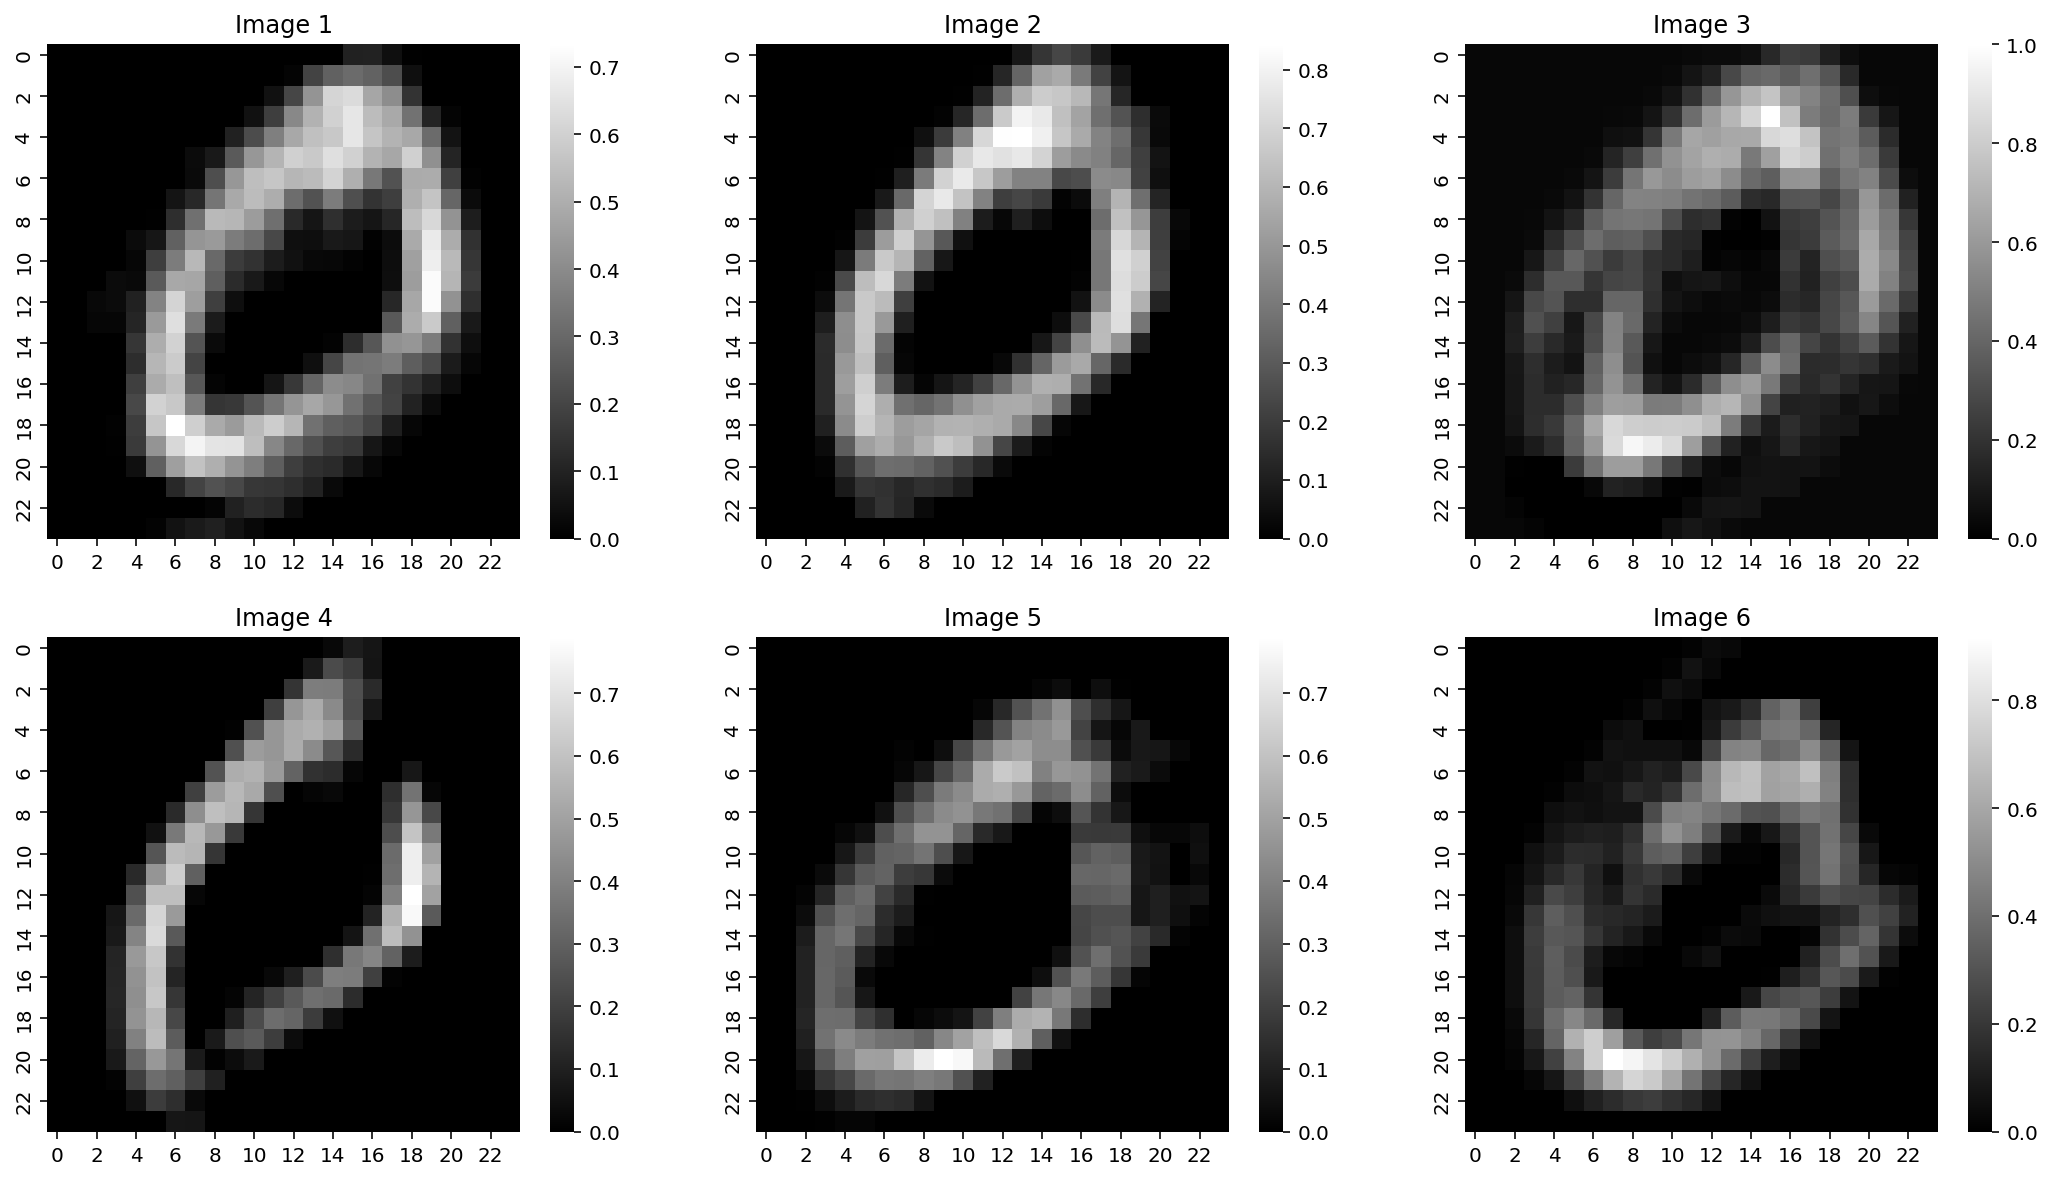

In [17]:
# Visualizae the output of the first convolutional layer

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
ax = axes.ravel()

for i in range(6):
    sns.heatmap(c1[0][i].detach().numpy(), ax=ax[i], cmap='gray')
    ax[i].set_title('Image {}'.format(i+1))

torch.Size([1, 6, 12, 12])
1 image, 6 channels, 12x12 pixels

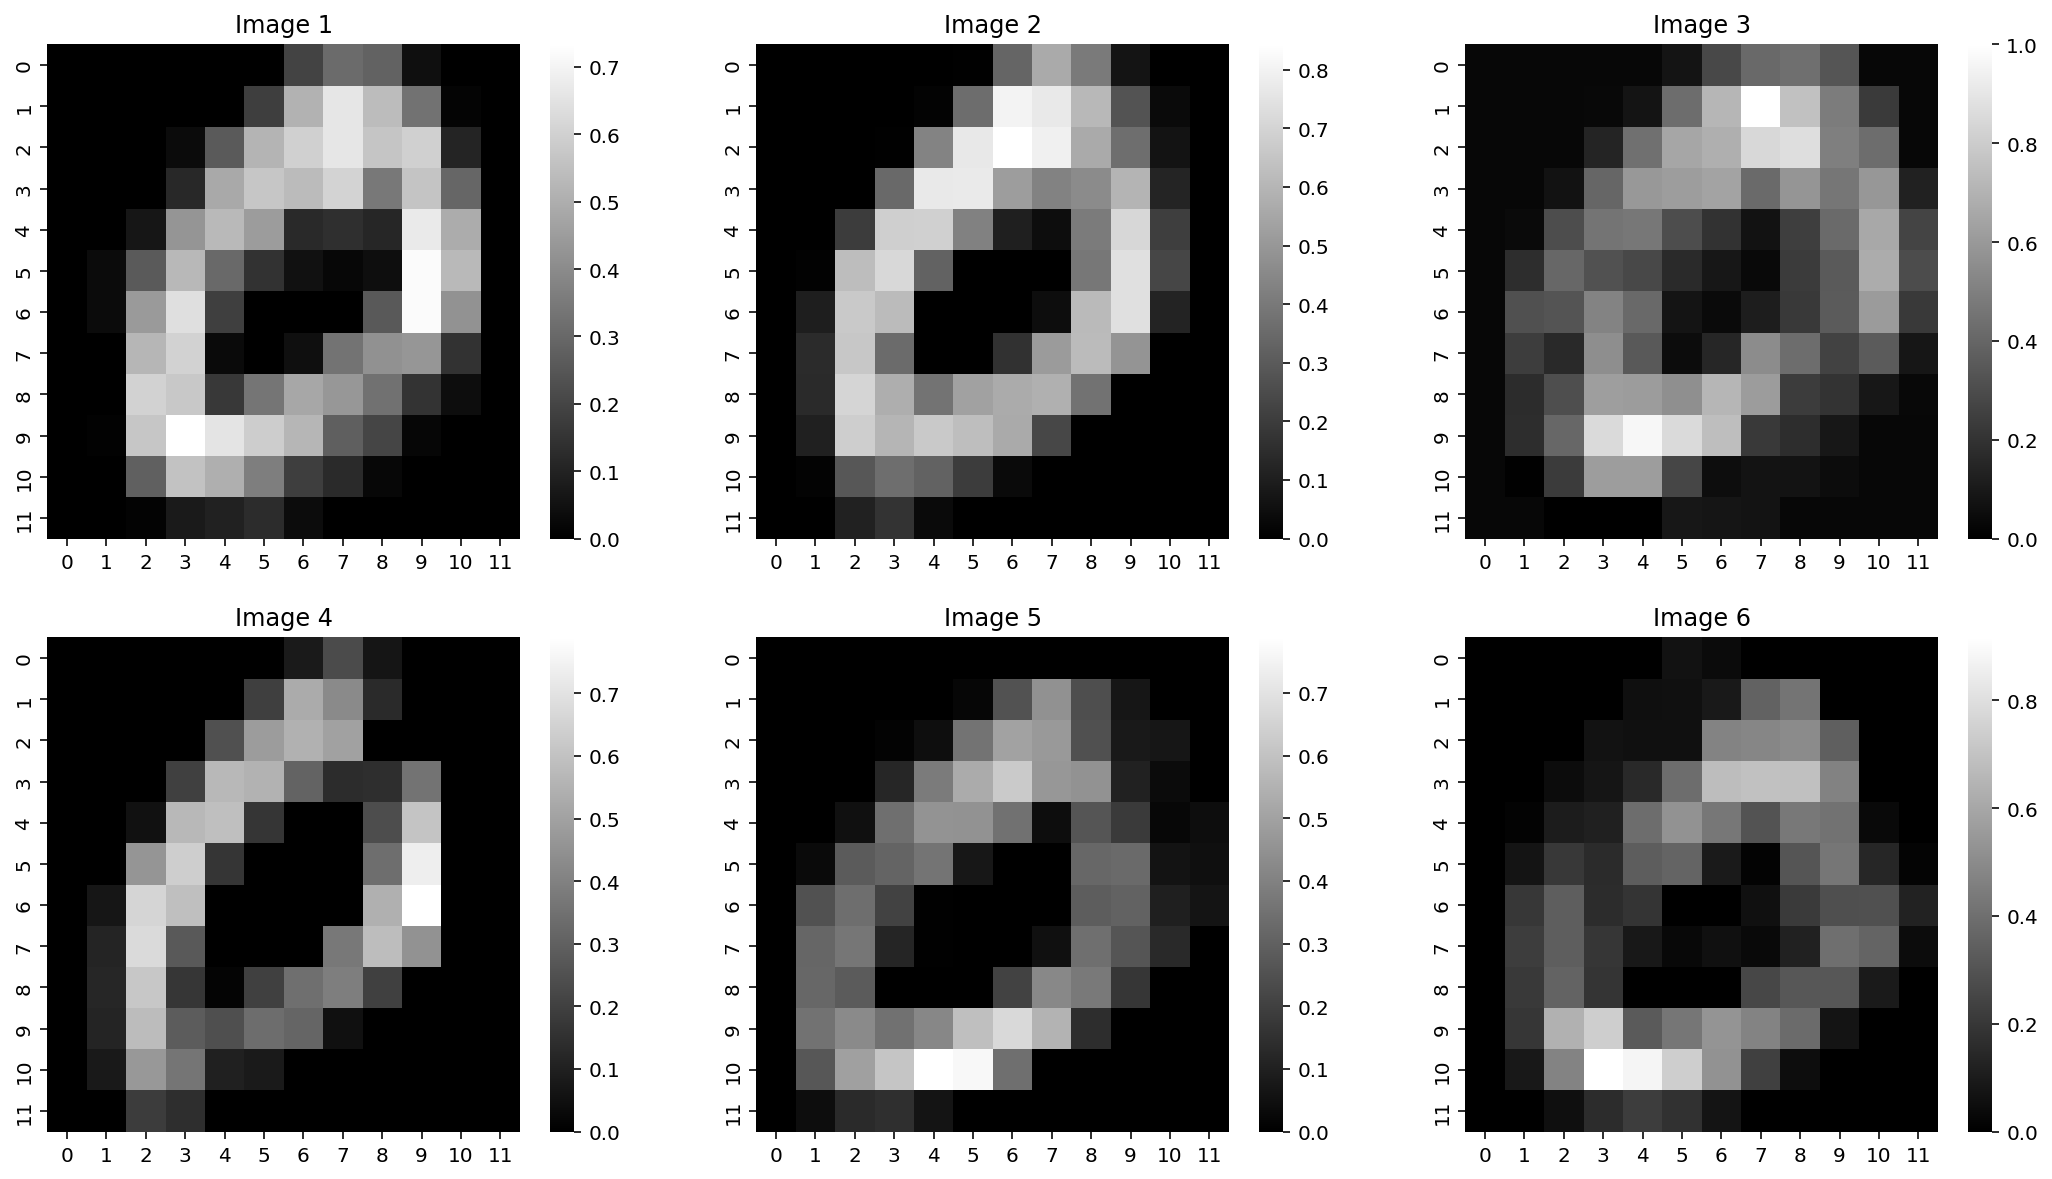

In [18]:
# Get output from model after max pooling

pool1 = F.max_pool2d(conv1, 2)

# For plotting bring all the images to the same scale
p1 = pool1 - pool1.min()
p1 = p1 / pool1.max()

print(p1.shape)
print("1 image, 6 channels, 12x12 pixels")

# Visualizae the output of the first convolutional layer

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
ax = axes.ravel()

for i in range(6):
    sns.heatmap(p1[0][i].detach().numpy(), ax=ax[i], cmap='gray')
    ax[i].set_title('Image {}'.format(i+1))

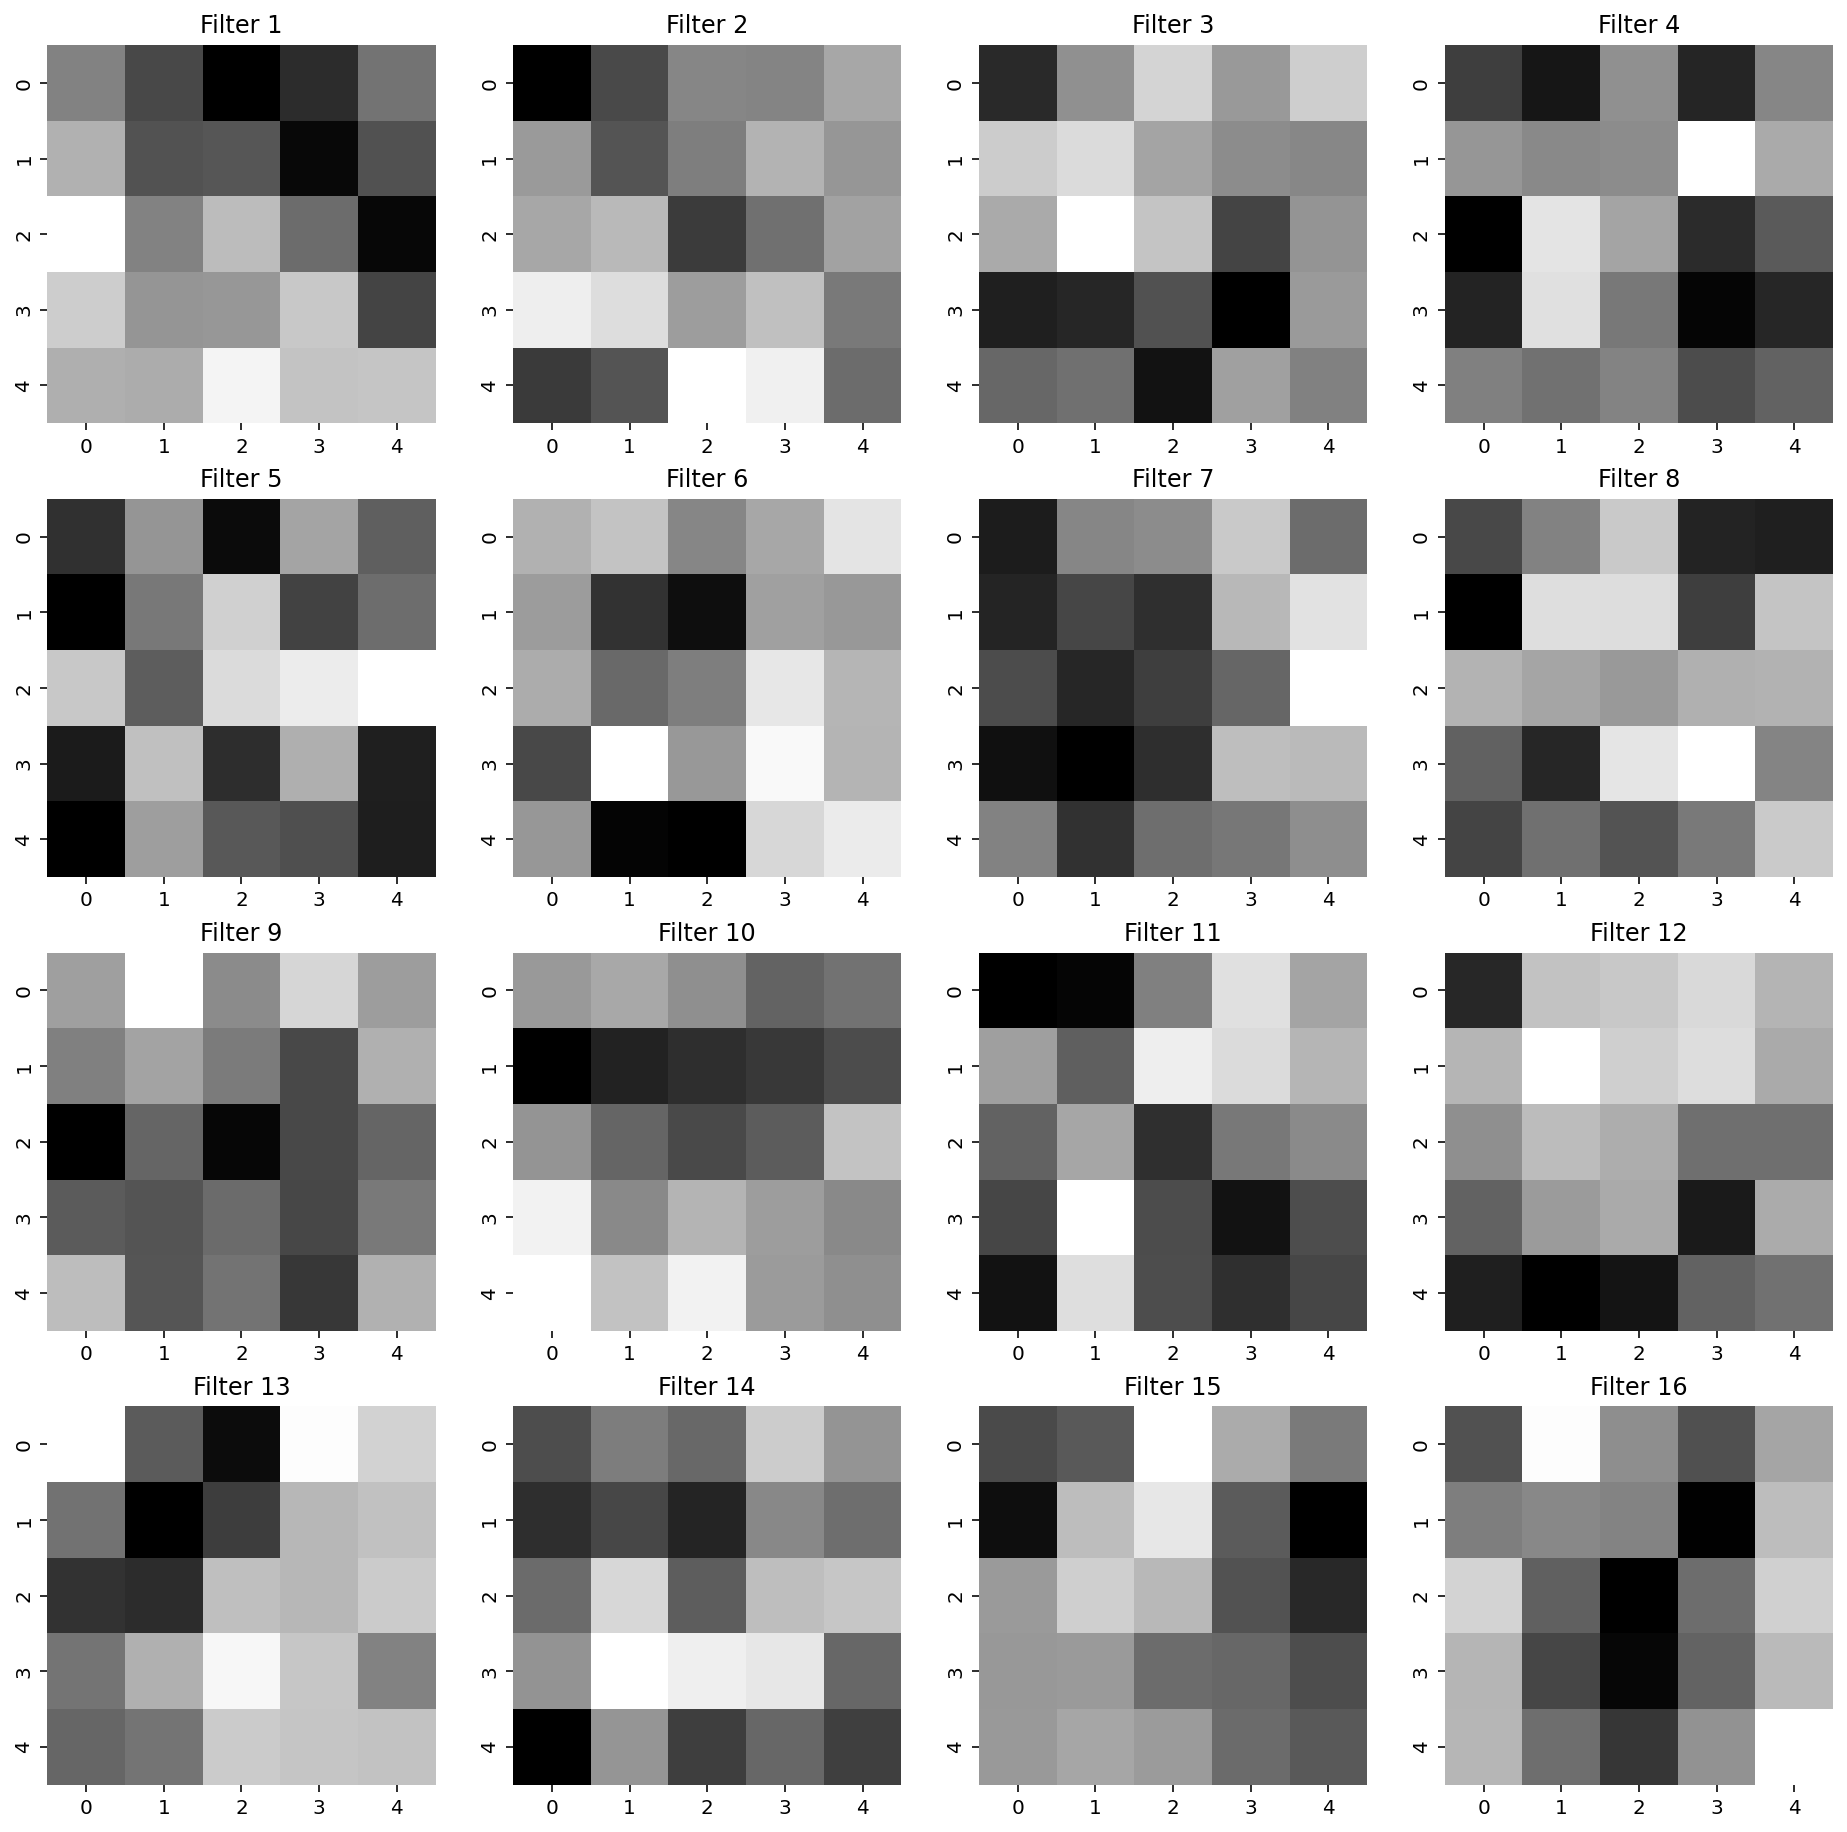

In [19]:
# Visualize the filters in the second convolutional layer

weights = model.conv2.weight.data
w = weights.numpy()

# Plot the weights

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
ax = axes.ravel()

for i in range(16):
    sns.heatmap(w[i][0], ax=ax[i], cmap='gray', cbar=False)
    ax[i].set_title('Filter {}'.format(i+1))

torch.Size([1, 16, 8, 8])
1 image, 16 channels, 8x8 pixels

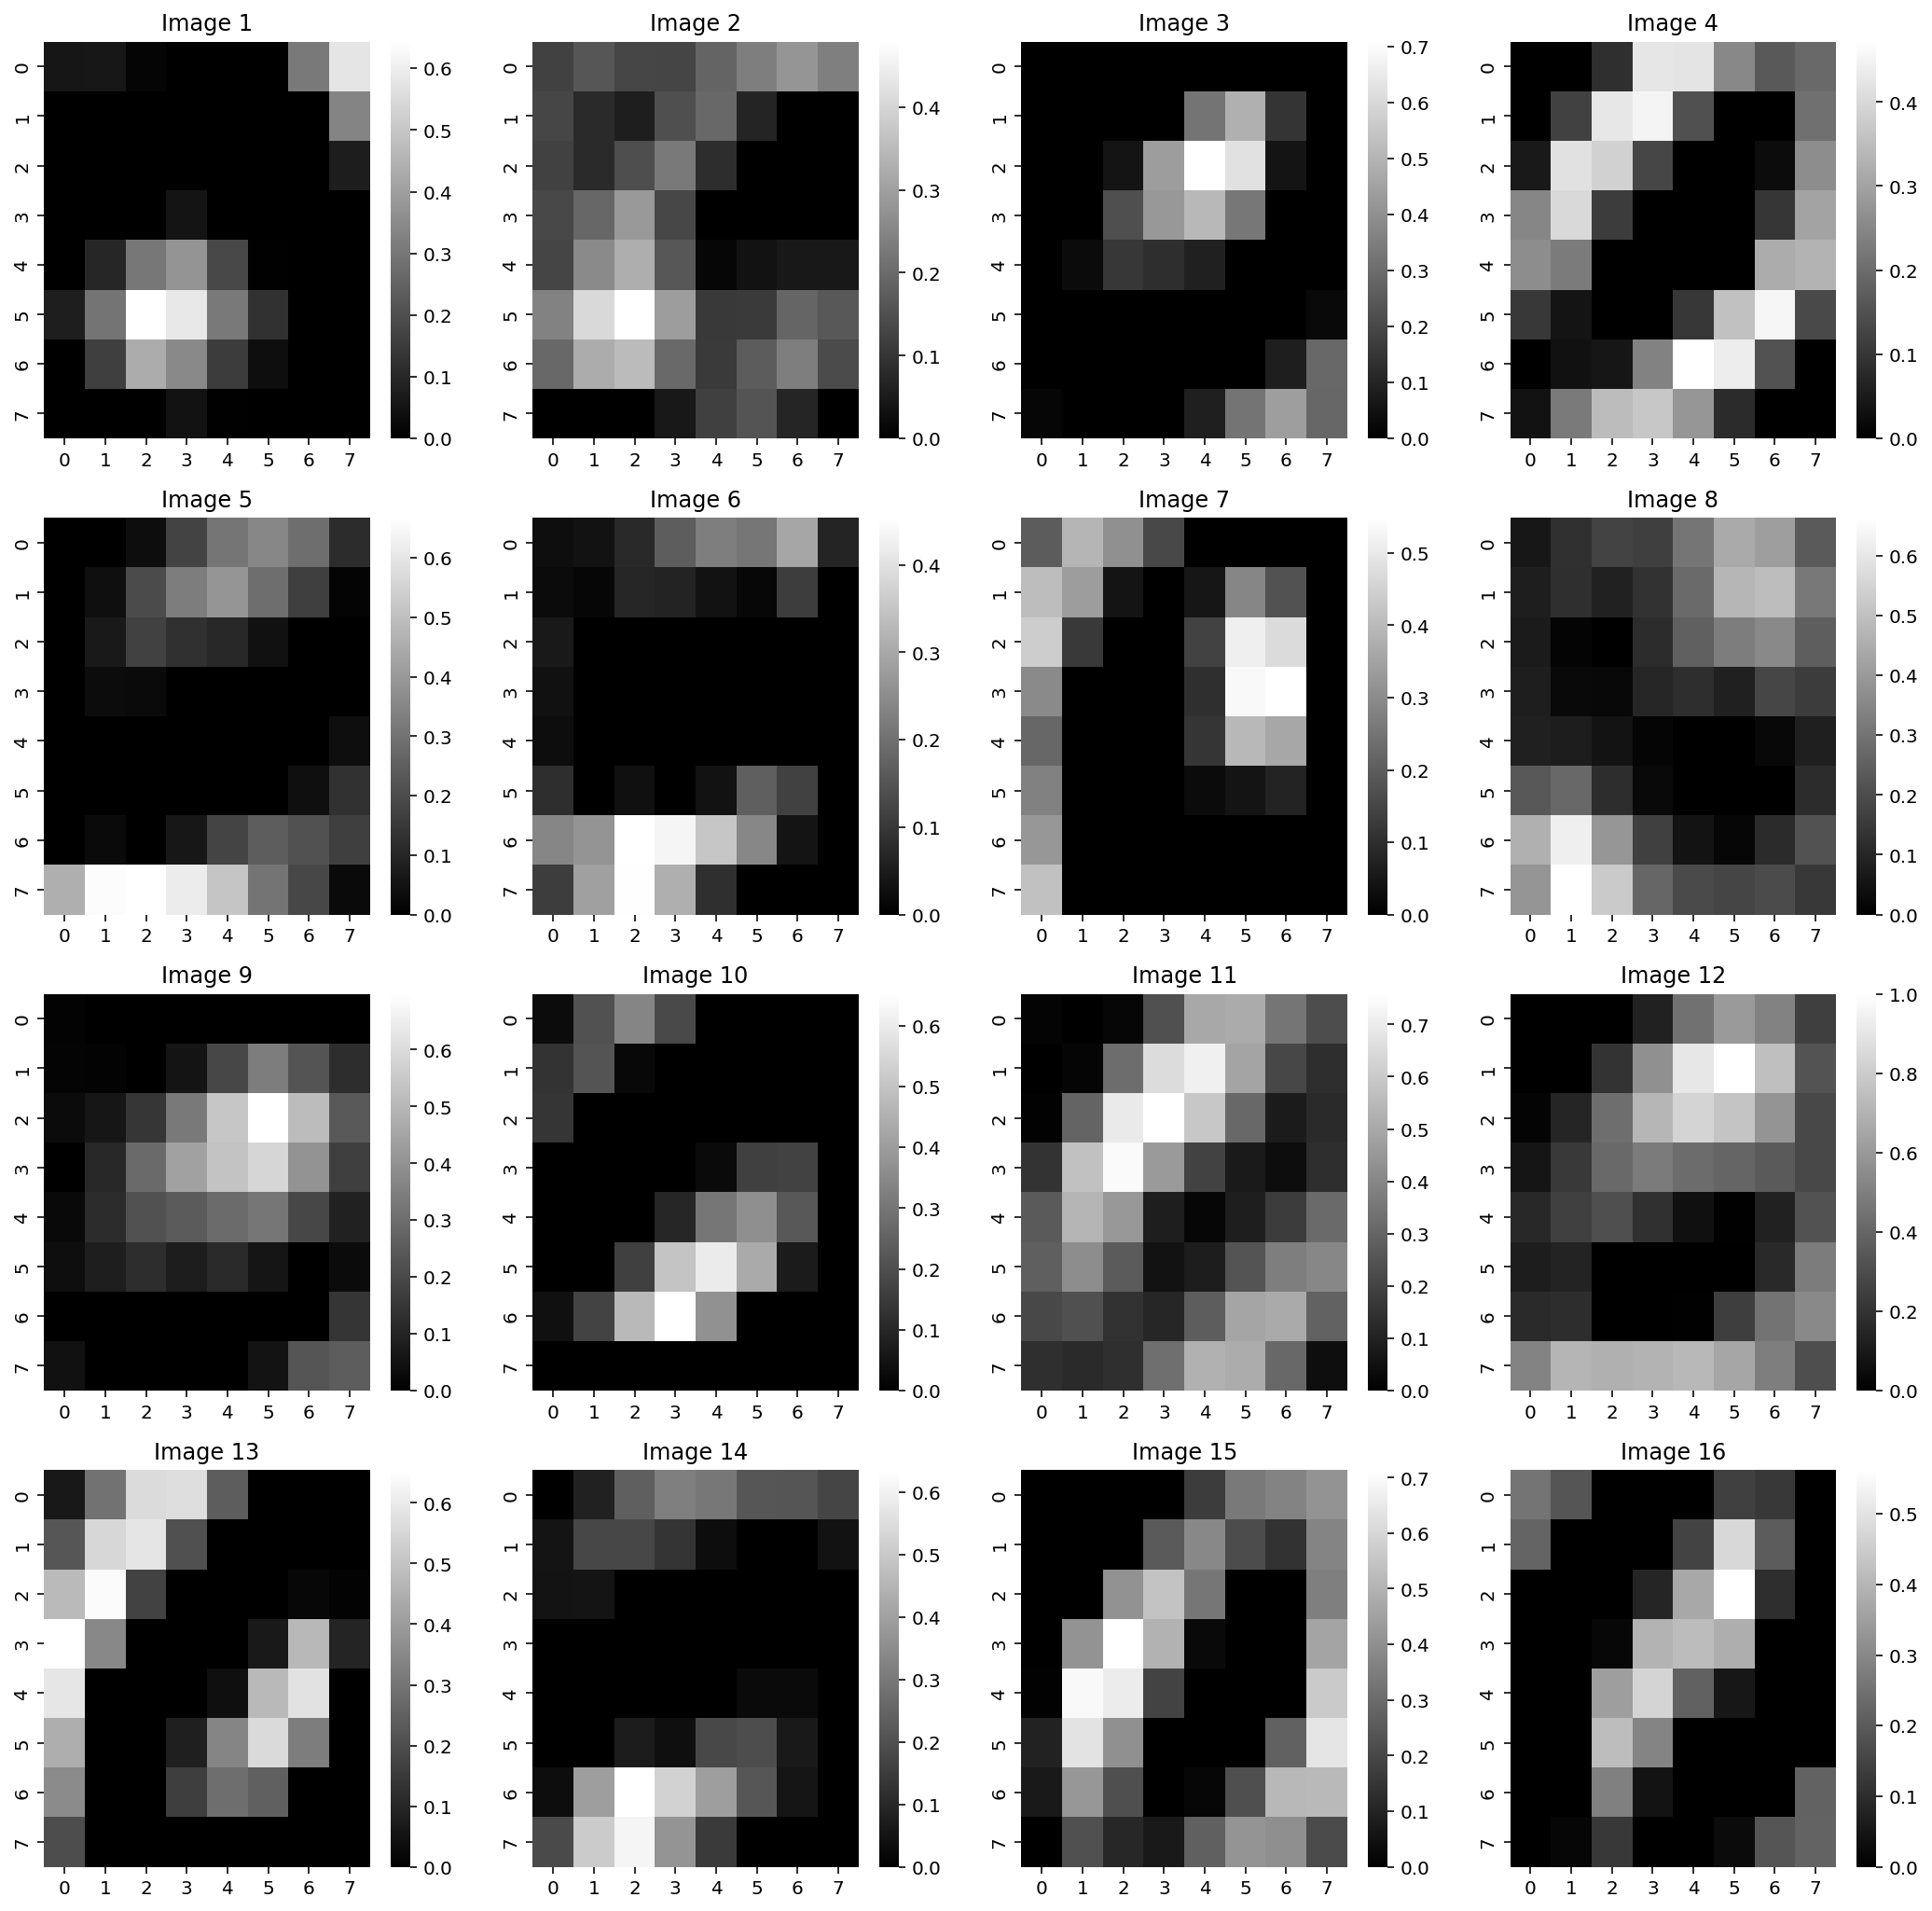

In [20]:
# Get output from model's second conv2 layer

conv2 = F.relu(model.conv2(pool1))

# For plotting bring all the images to the same scale
c2 = conv2 - conv2.min()
c2 = c2 / conv2.max()

print(c2.shape)
print("1 image, 16 channels, 8x8 pixels")

# Visualizae the output of the first convolutional layer

fig, axes = plt.subplots(4, 4, figsize=(18, 18))
ax = axes.ravel()

for i in range(16):
    sns.heatmap(c2[0][i].detach().numpy(), ax=ax[i], cmap='gray')
    ax[i].set_title('Image {}'.format(i+1))

torch.Size([1, 16, 4, 4])
1 image, 16 channels, 4x4 pixels

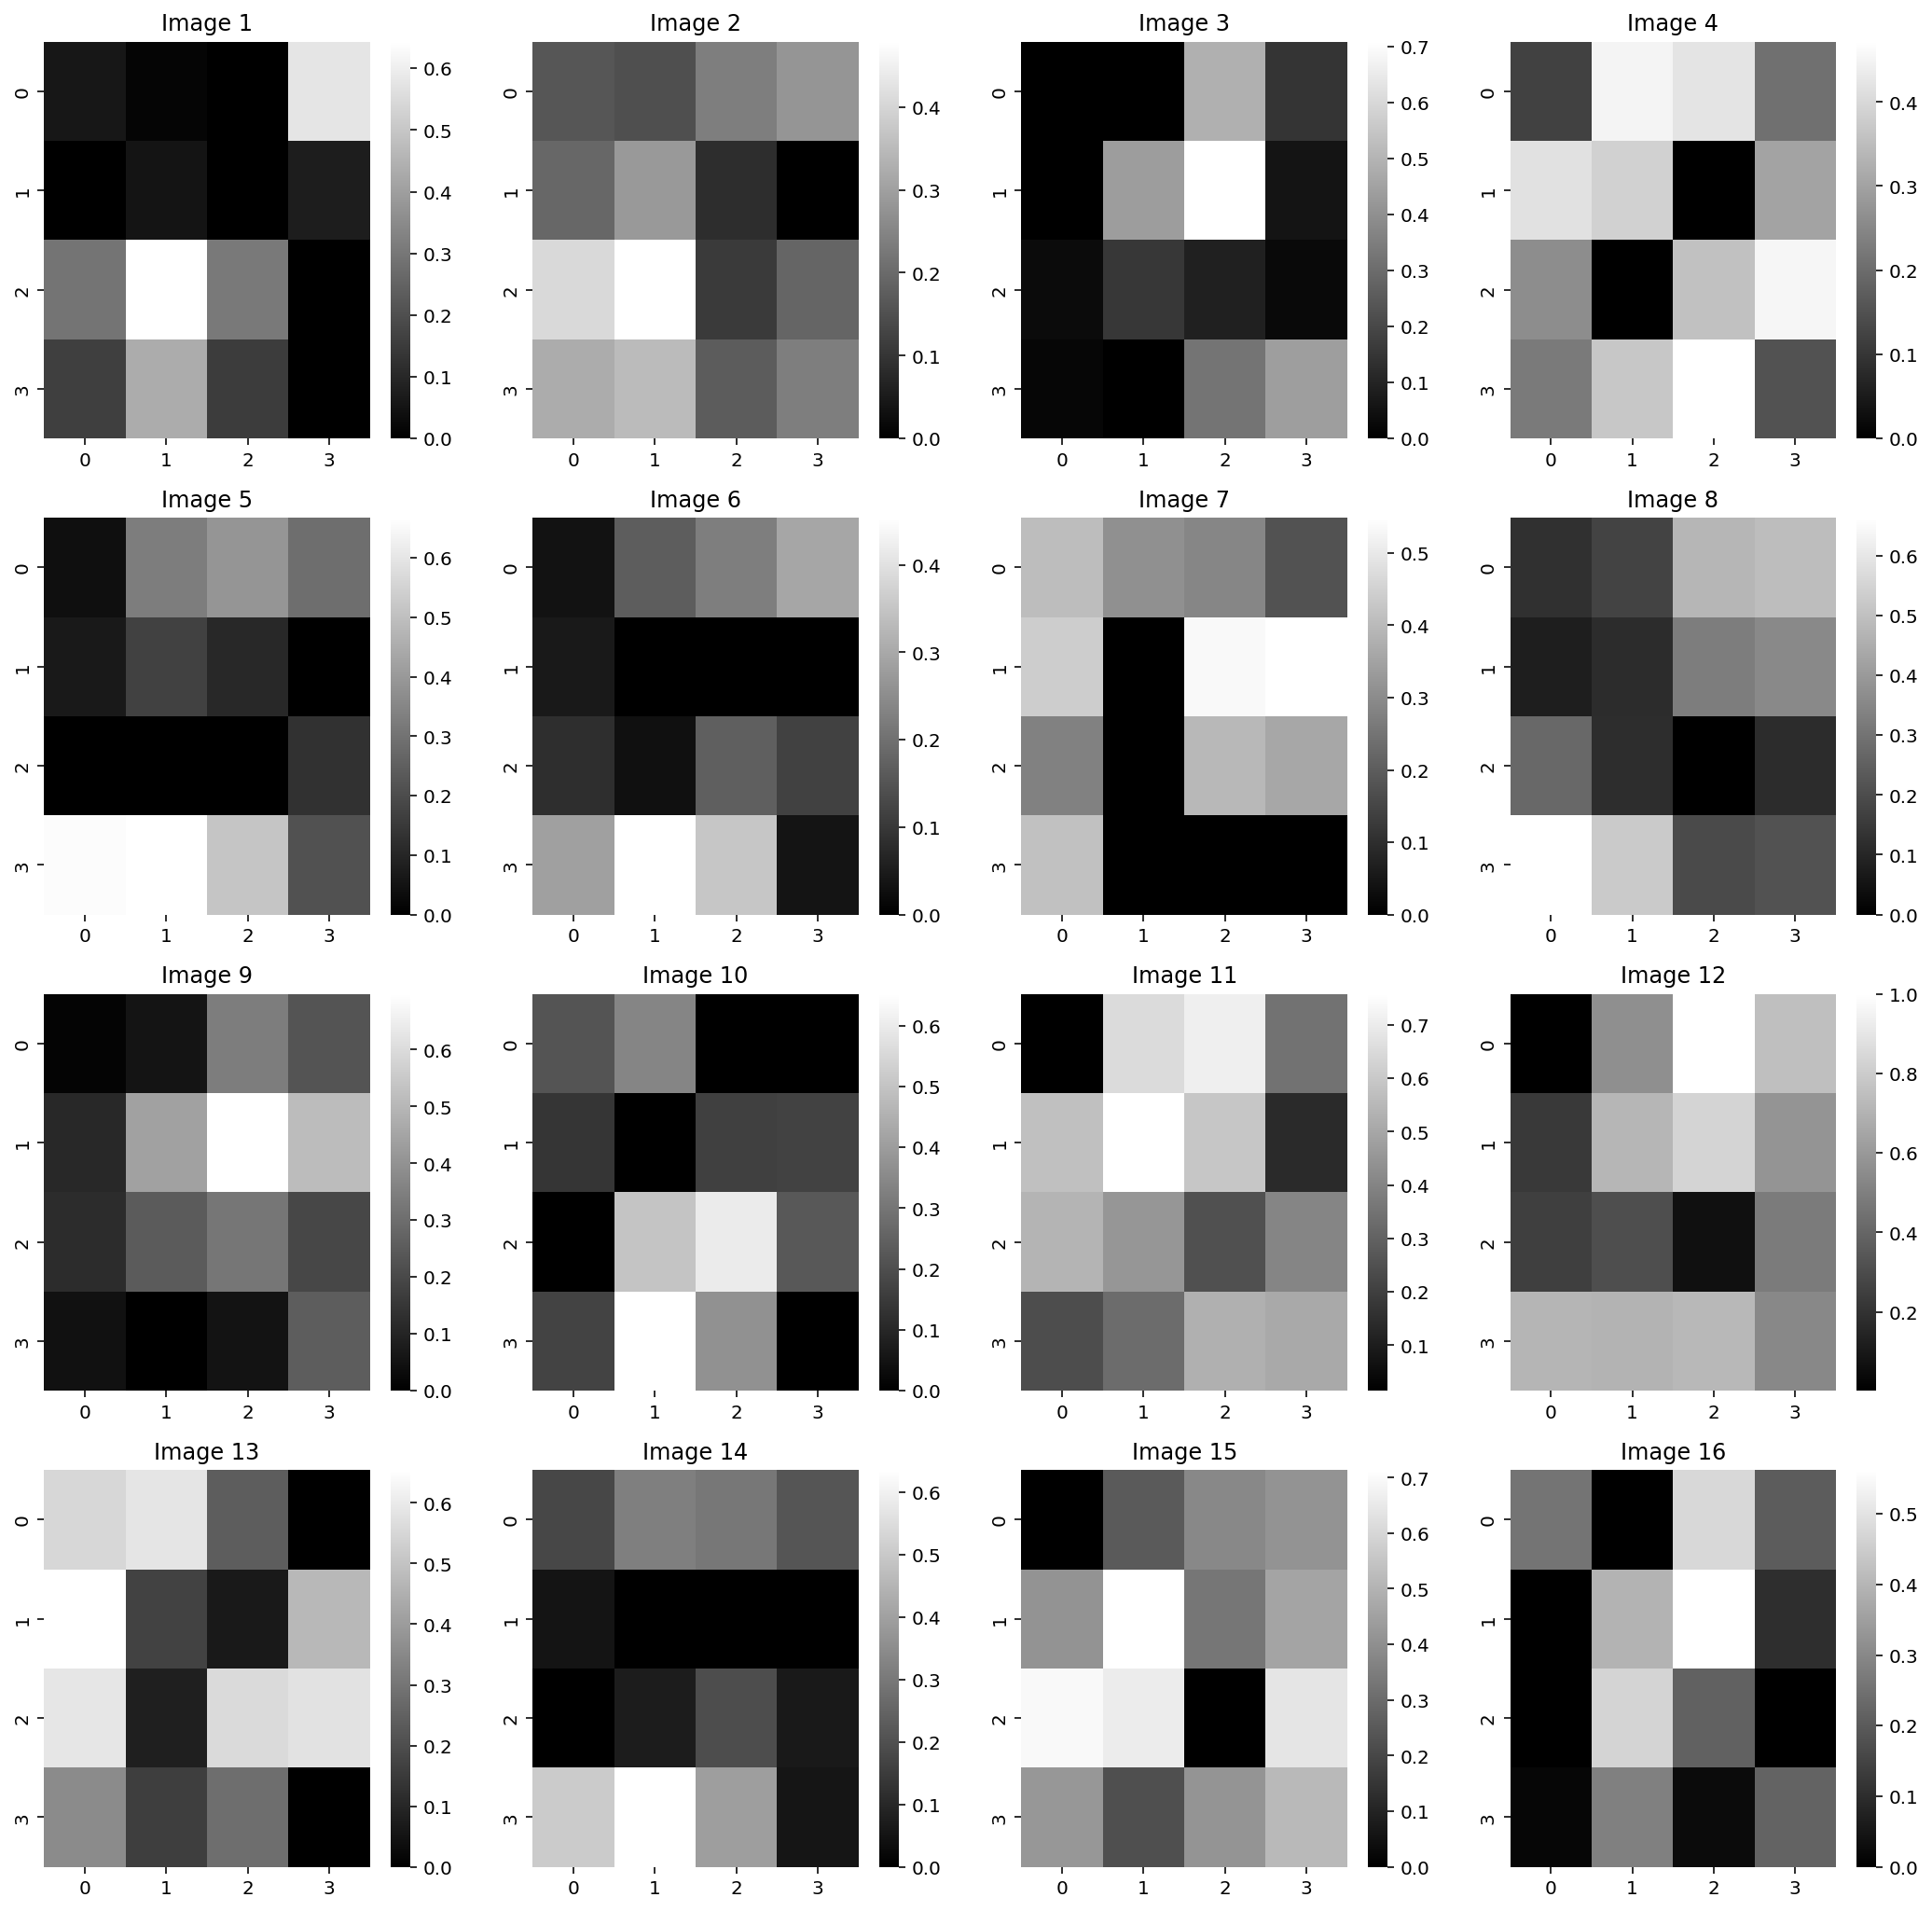

In [21]:
# Get output from model after max pooling

pool2 = F.max_pool2d(conv2, 2)

# For plotting bring all the images to the same scale
p2 = pool2 - pool2.min()
p2 = p2 / pool2.max()

print(p2.shape)
print("1 image, 16 channels, 4x4 pixels")

# Visualizae the output of the first convolutional layer

fig, axes = plt.subplots(4, 4, figsize=(18, 18))
ax = axes.ravel()

for i in range(16):
    sns.heatmap(p2[0][i].detach().numpy(), ax=ax[i], cmap='gray')
    ax[i].set_title('Image {}'.format(i+1))


In [22]:
# Flatten the output of the second convolutional layer

flat = pool2.view(pool2.size(0), -1)
print(flat.shape)


torch.Size([1, 256])

In [46]:
# Repeat the above process as a function to visualize the convolution outputs for any image for any layer
def scale_img(img):
    """
    Scale the image to the same scale
    """
    img = img - img.min()
    img = img / img.max()
    return img

def visualize_conv_output(model, img):
    """
    Visualize the output of a convolutional layer
    """
    # Get output from model's first conv1 layer
    conv1 = F.relu(model.conv1(img))

    # For plotting bring all the images to the same scale
    c1 = scale_img(conv1)

    # Visualizae the output of the first convolutional layer
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    ax = axes.ravel()


    for i in range(6):
        sns.heatmap(c1[0][i].detach().numpy(), ax=ax[i], cmap='gray')
        ax[i].set_title('Image {}'.format(i+1))
    # Add title to the figure
    fig.suptitle('Convolutional Layer 1', fontsize=16)
    
    # Get output from model after max pooling
    pool1 = F.max_pool2d(conv1, 2)

    # For plotting bring all the images to the same scale
    p1 = scale_img(pool1)

    # Visualizae the output of the first convolutional layer
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    ax = axes.ravel()


    for i in range(6):
        sns.heatmap(p1[0][i].detach().numpy(), ax=ax[i], cmap='gray')
        ax[i].set_title('Image {}'.format(i+1))
    # Add title to the figure
    fig.suptitle('Max Pooling Layer 1', fontsize=16)

    # Get output from model's second conv2 layer
    conv2 = F.relu(model.conv2(pool1))

    # For plotting bring all the images to the same scale
    c2 = scale_img(conv2)

    # Visualizae the output of the first convolutional layer
    fig, axes = plt.subplots(4, 4, figsize=(18, 18))
    ax = axes.ravel()

    
    for i in range(16):
        sns.heatmap(c2[0][i].detach().numpy(), ax=ax[i], cmap='gray')
        ax[i].set_title('Image {}'.format(i+1))
    # Add title to the figure
    fig.suptitle('Convolutional Layer 2', fontsize=16)

    # Get output from model after max pooling
    pool2 = F.max_pool2d(conv2, 2)

    # For plotting bring all the images to the same scale
    p2 = scale_img(pool2)

    # Visualizae the output of the first convolutional layer
    fig, axes = plt.subplots(4, 4, figsize=(18, 18))
    ax = axes.ravel()

    for i in range(16):
        sns.heatmap(p2[0][i].detach().numpy(), ax=ax[i], cmap='gray')
        ax[i].set_title('Image {}'.format(i+1))
    # Add title to the figure
    fig.suptitle('Max Pooling Layer 2', fontsize=16)


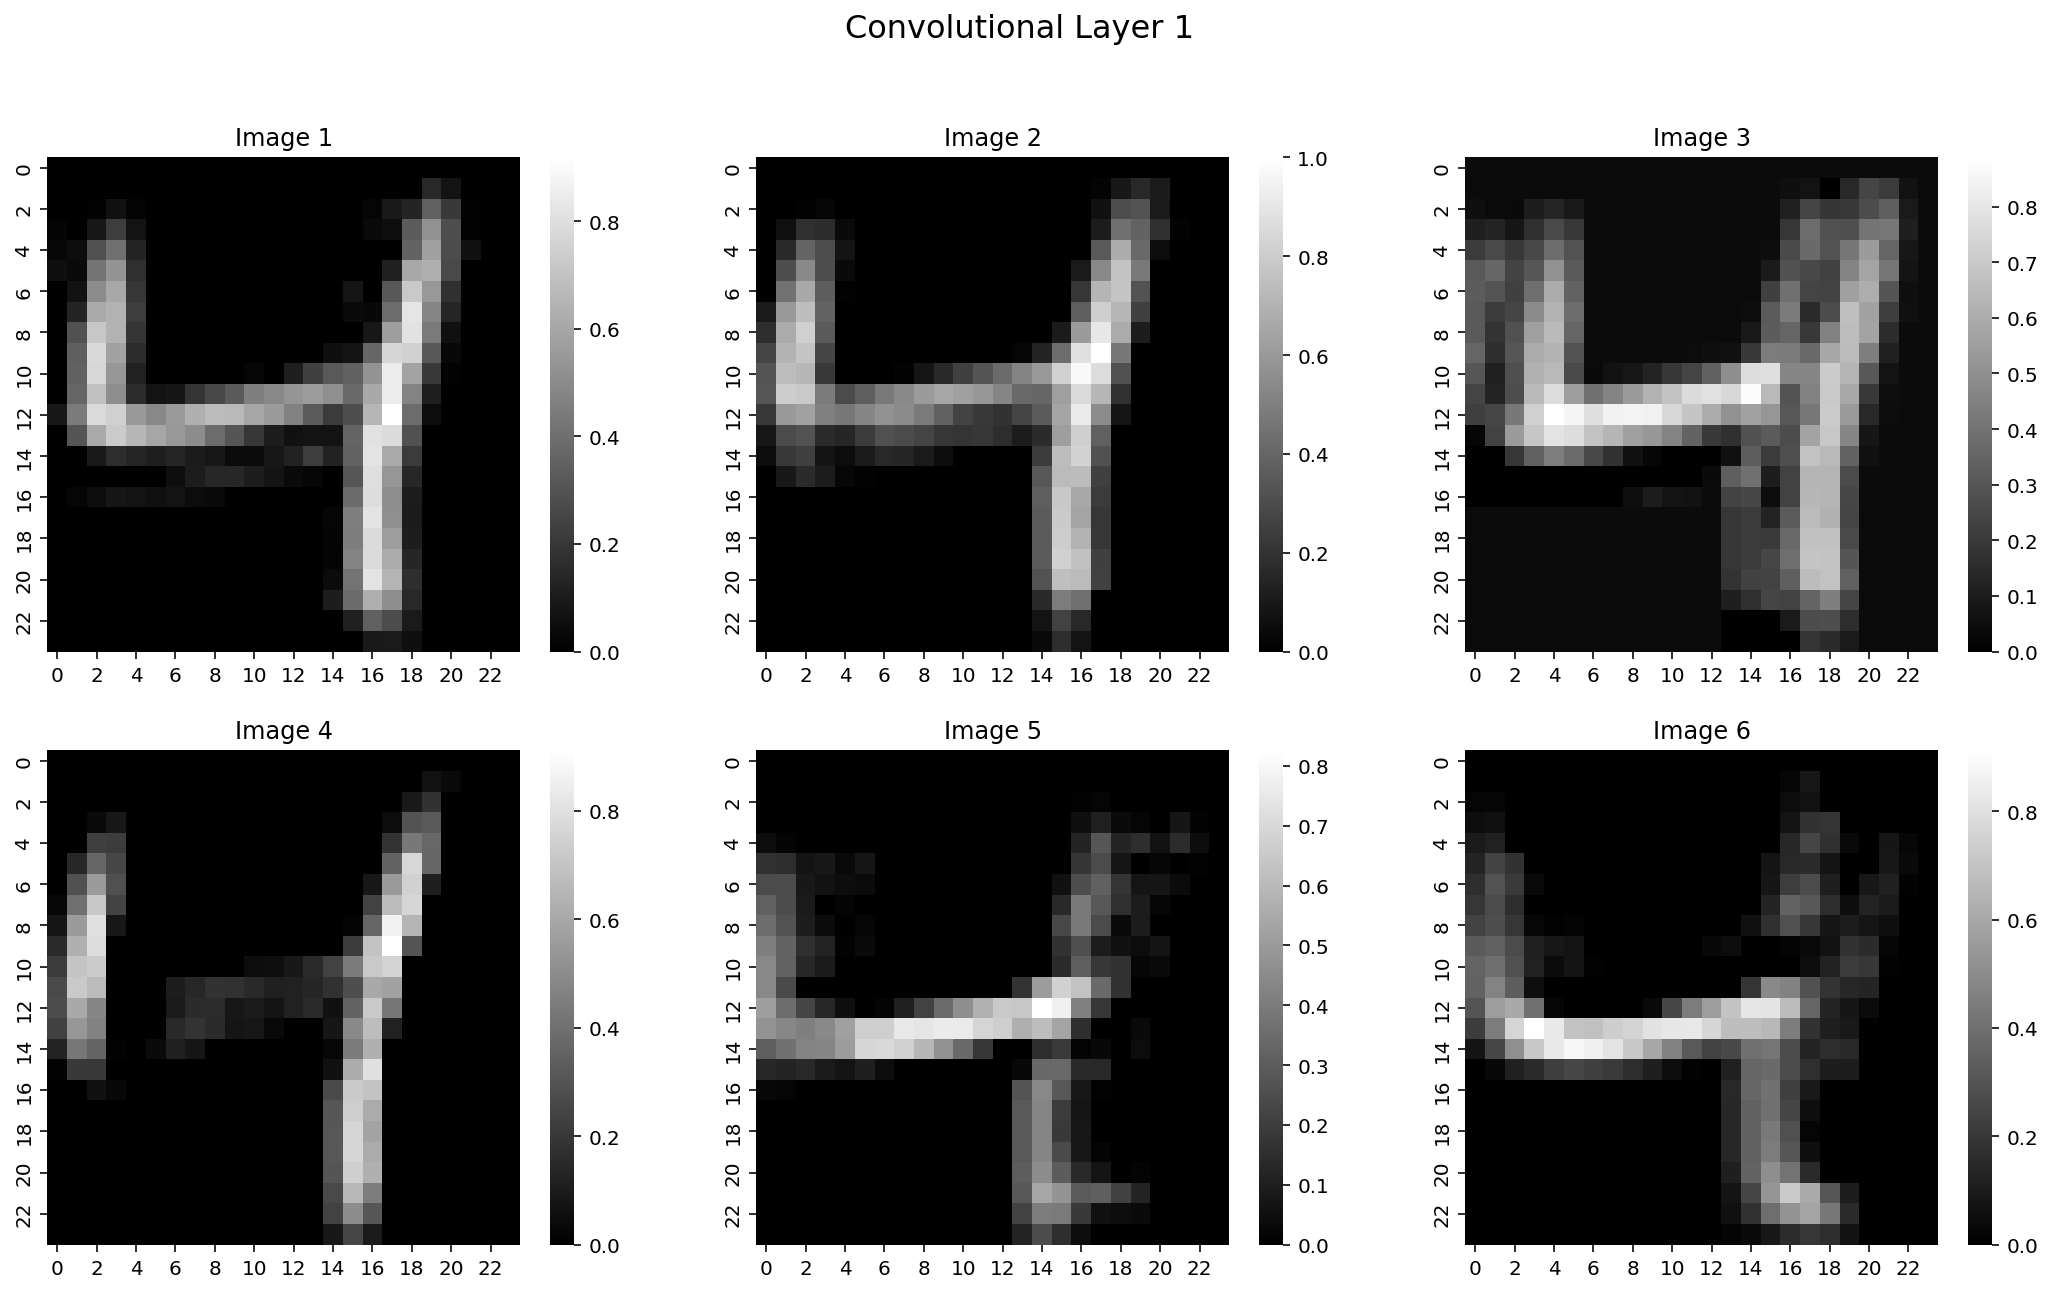

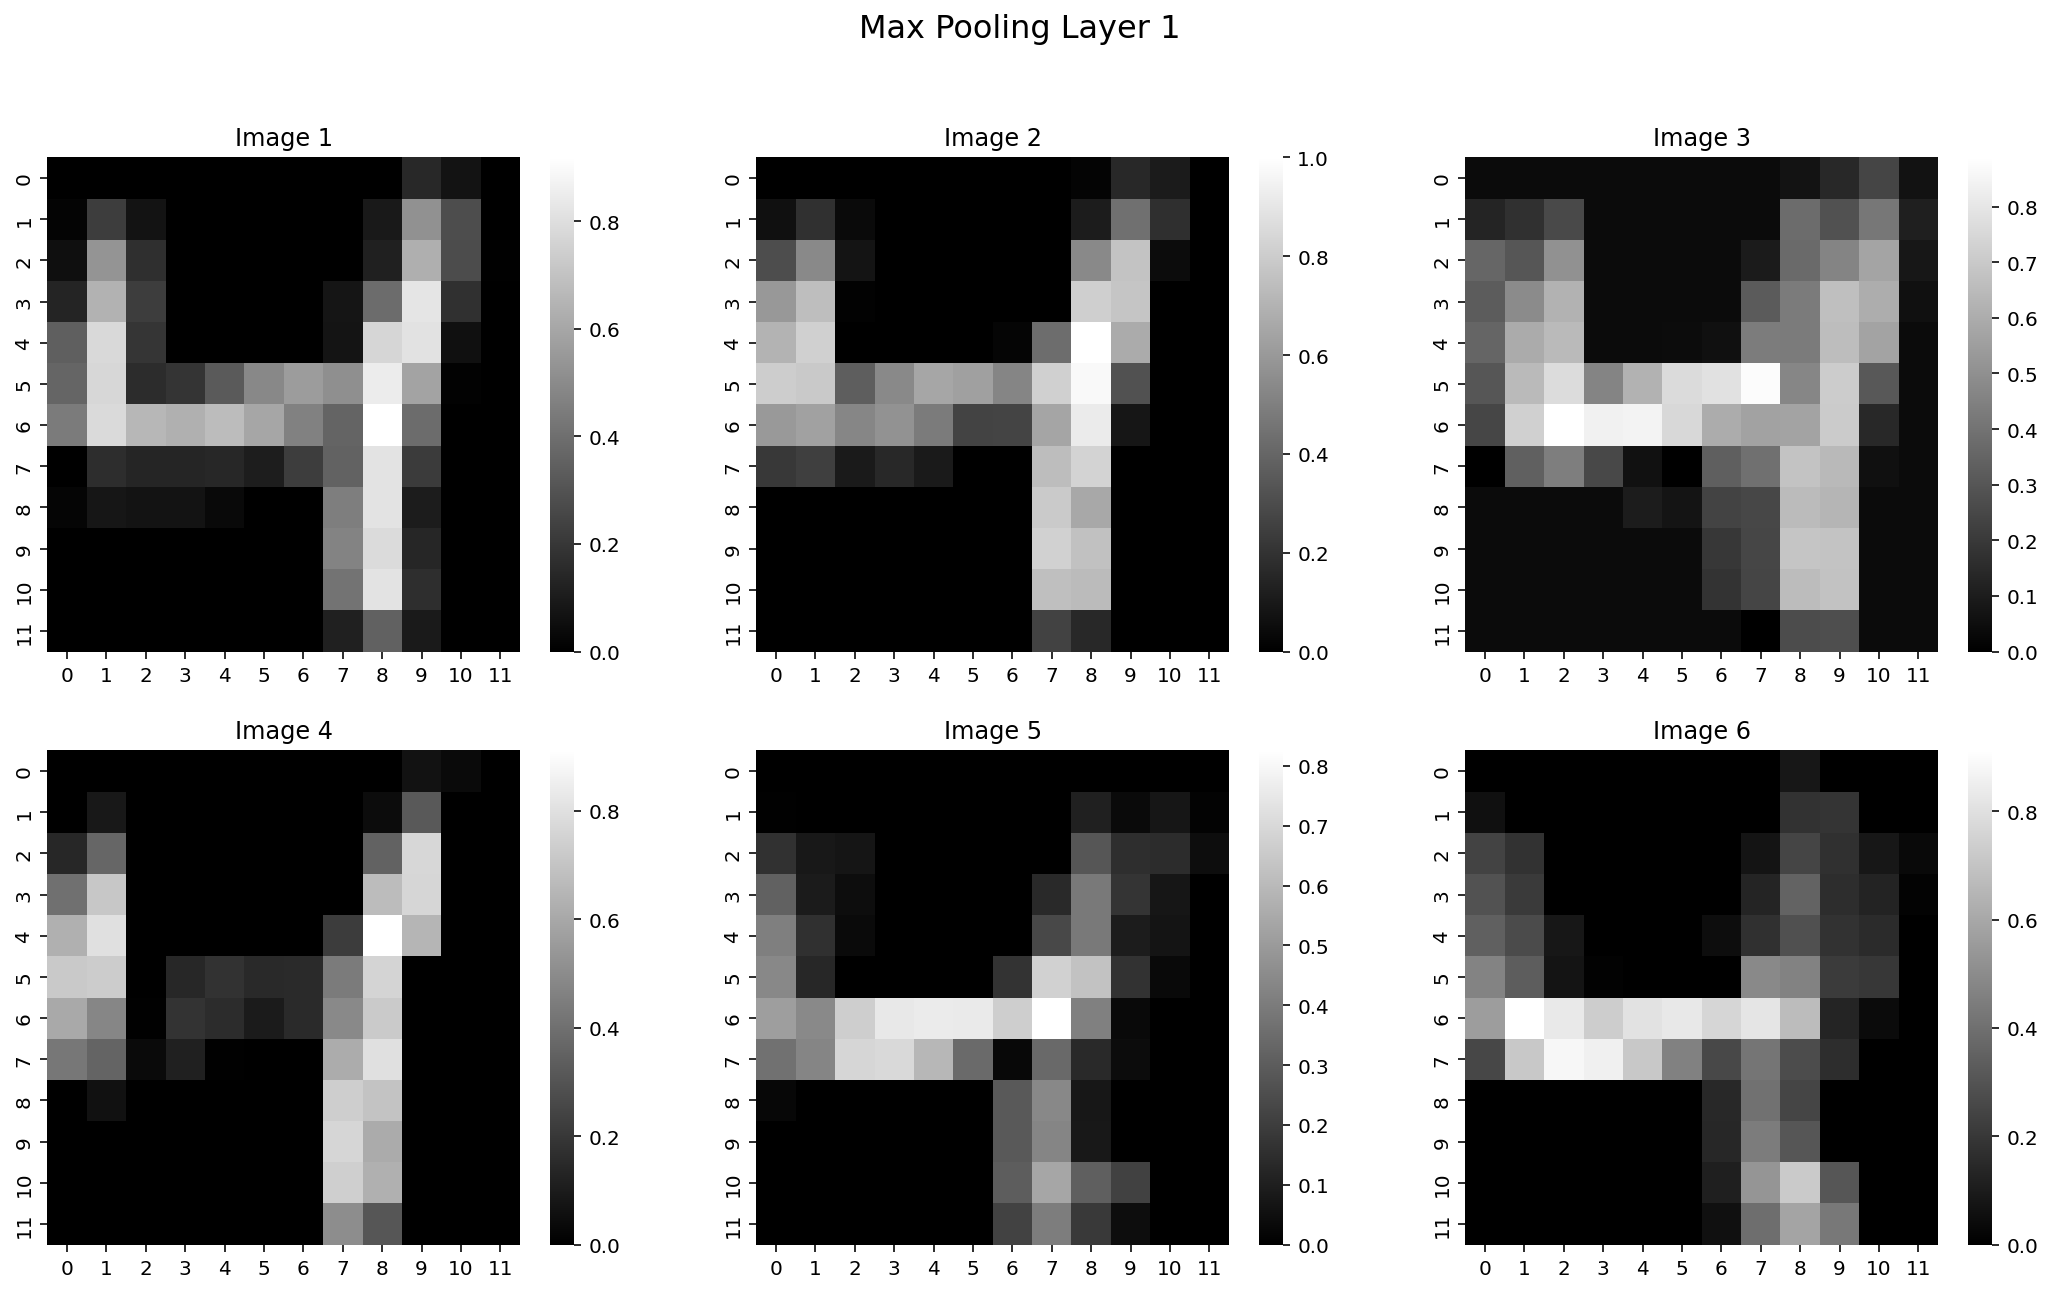

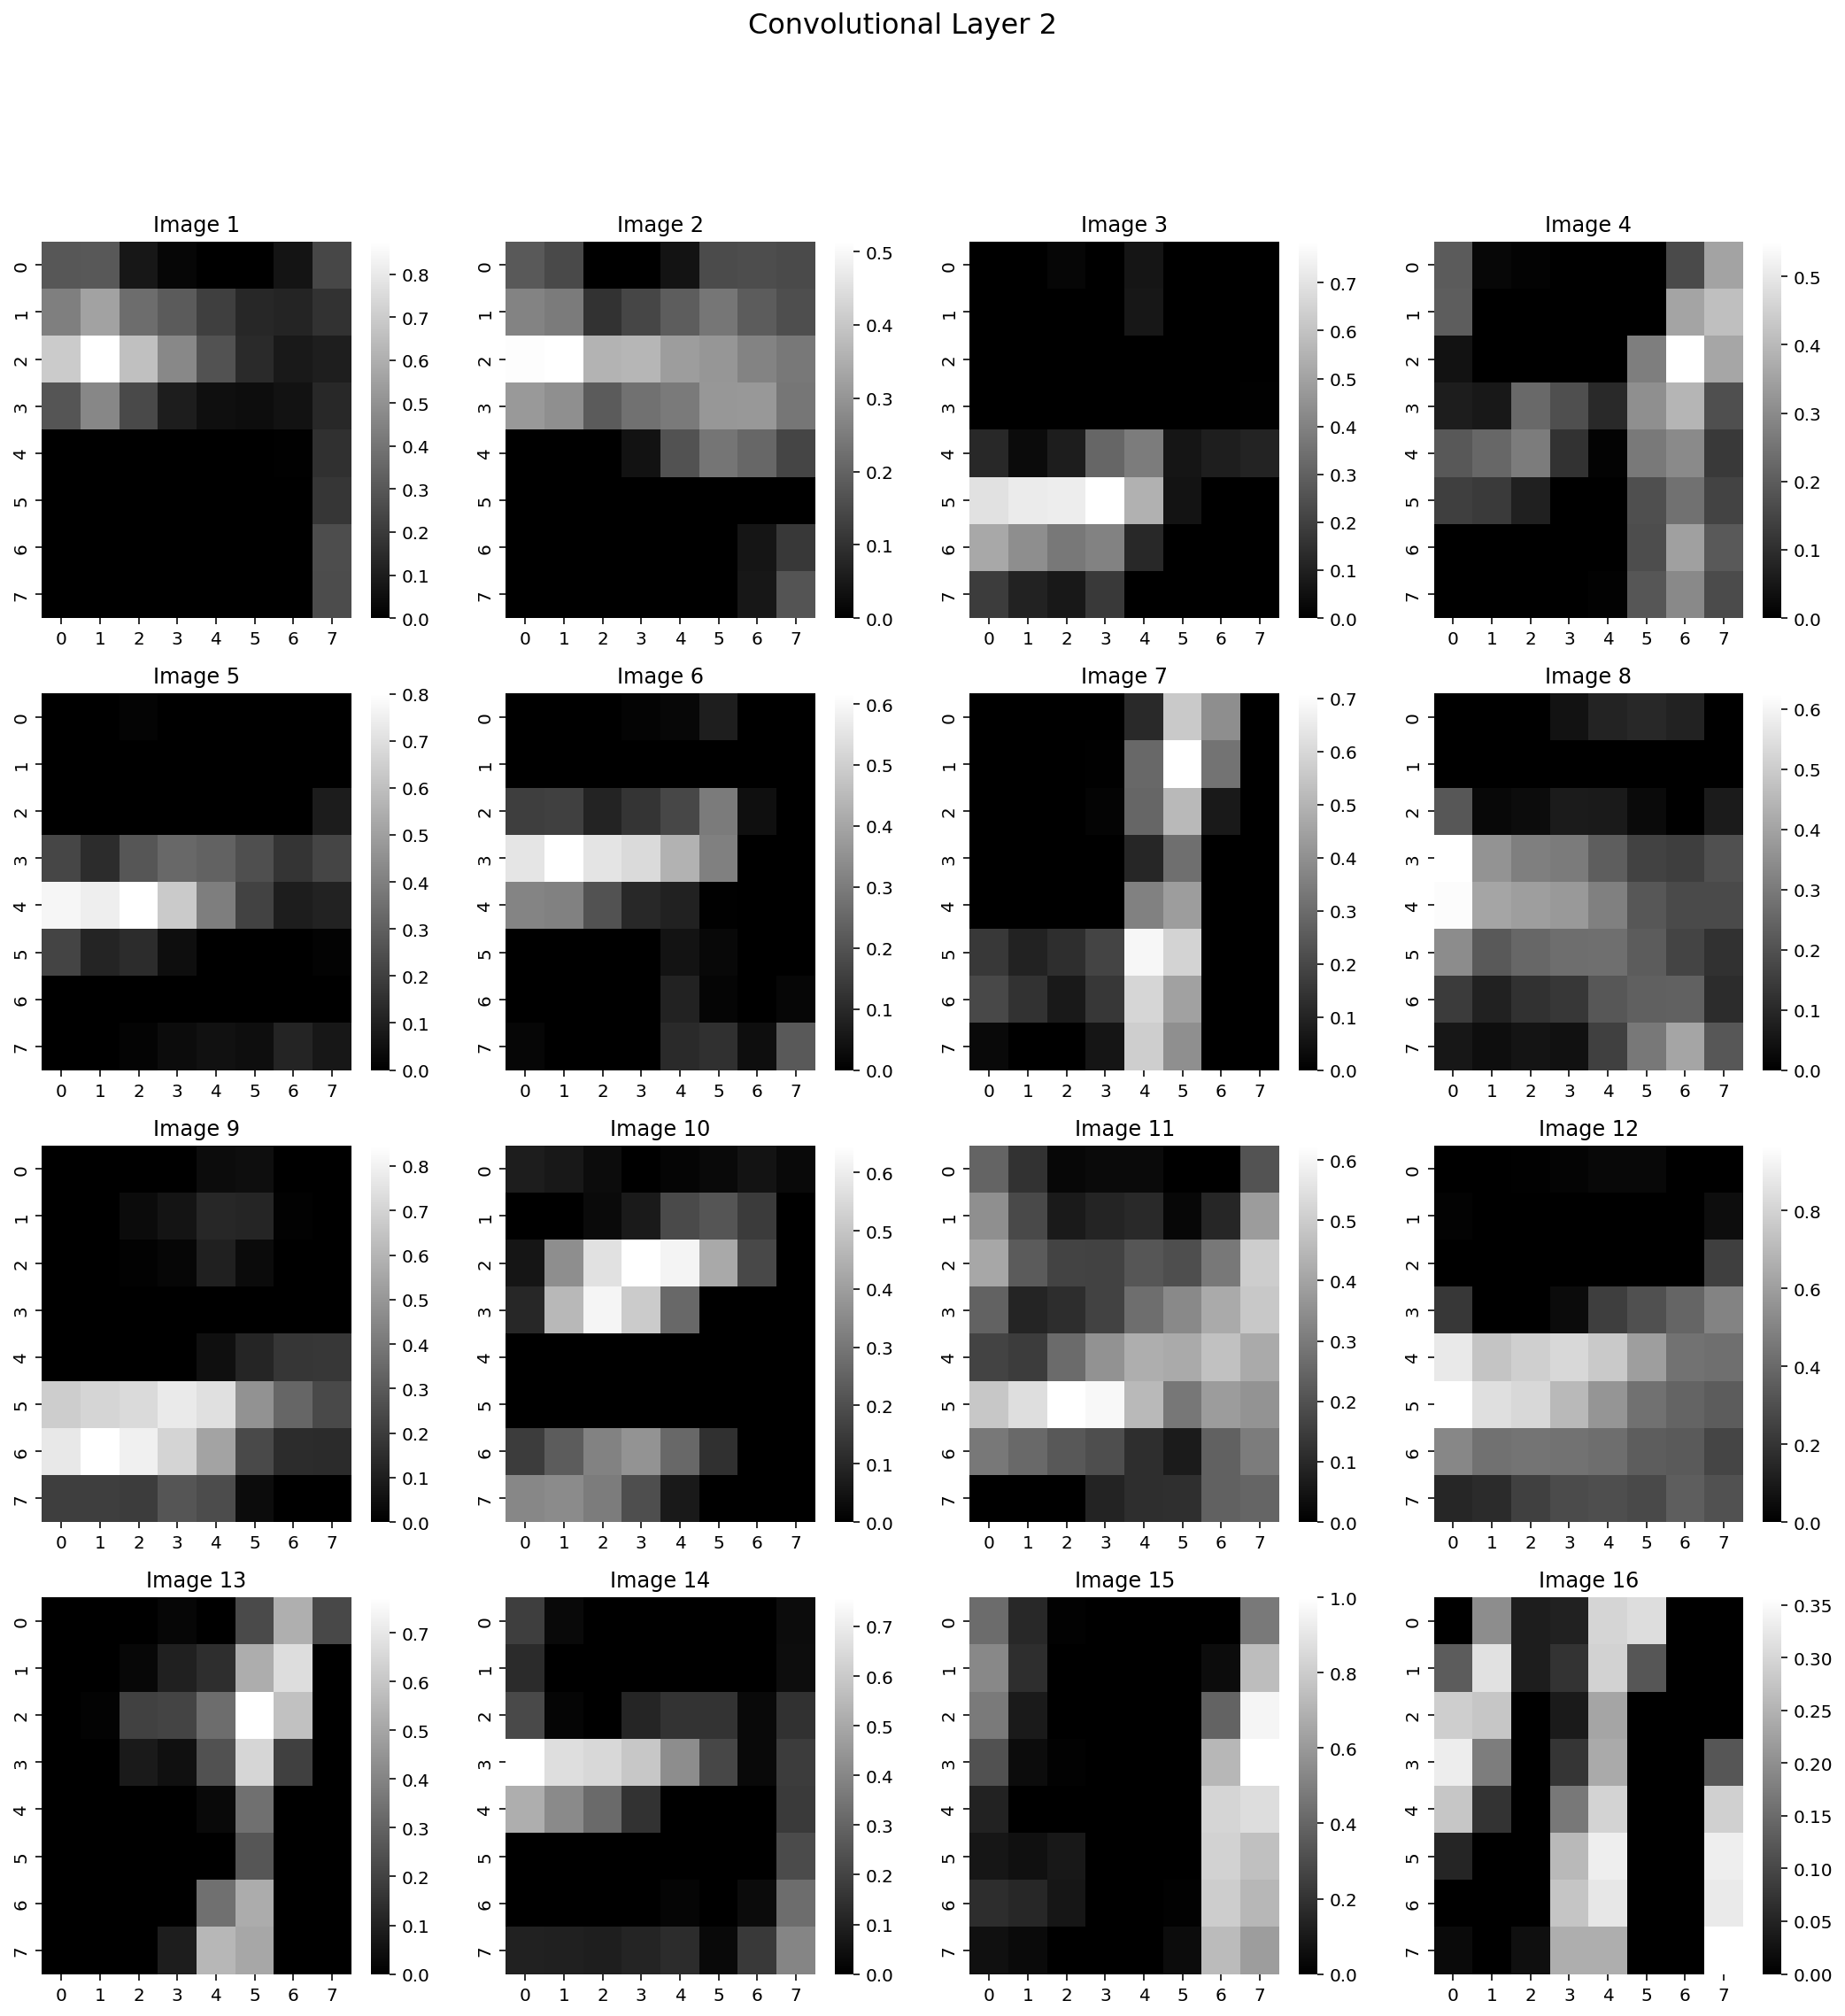

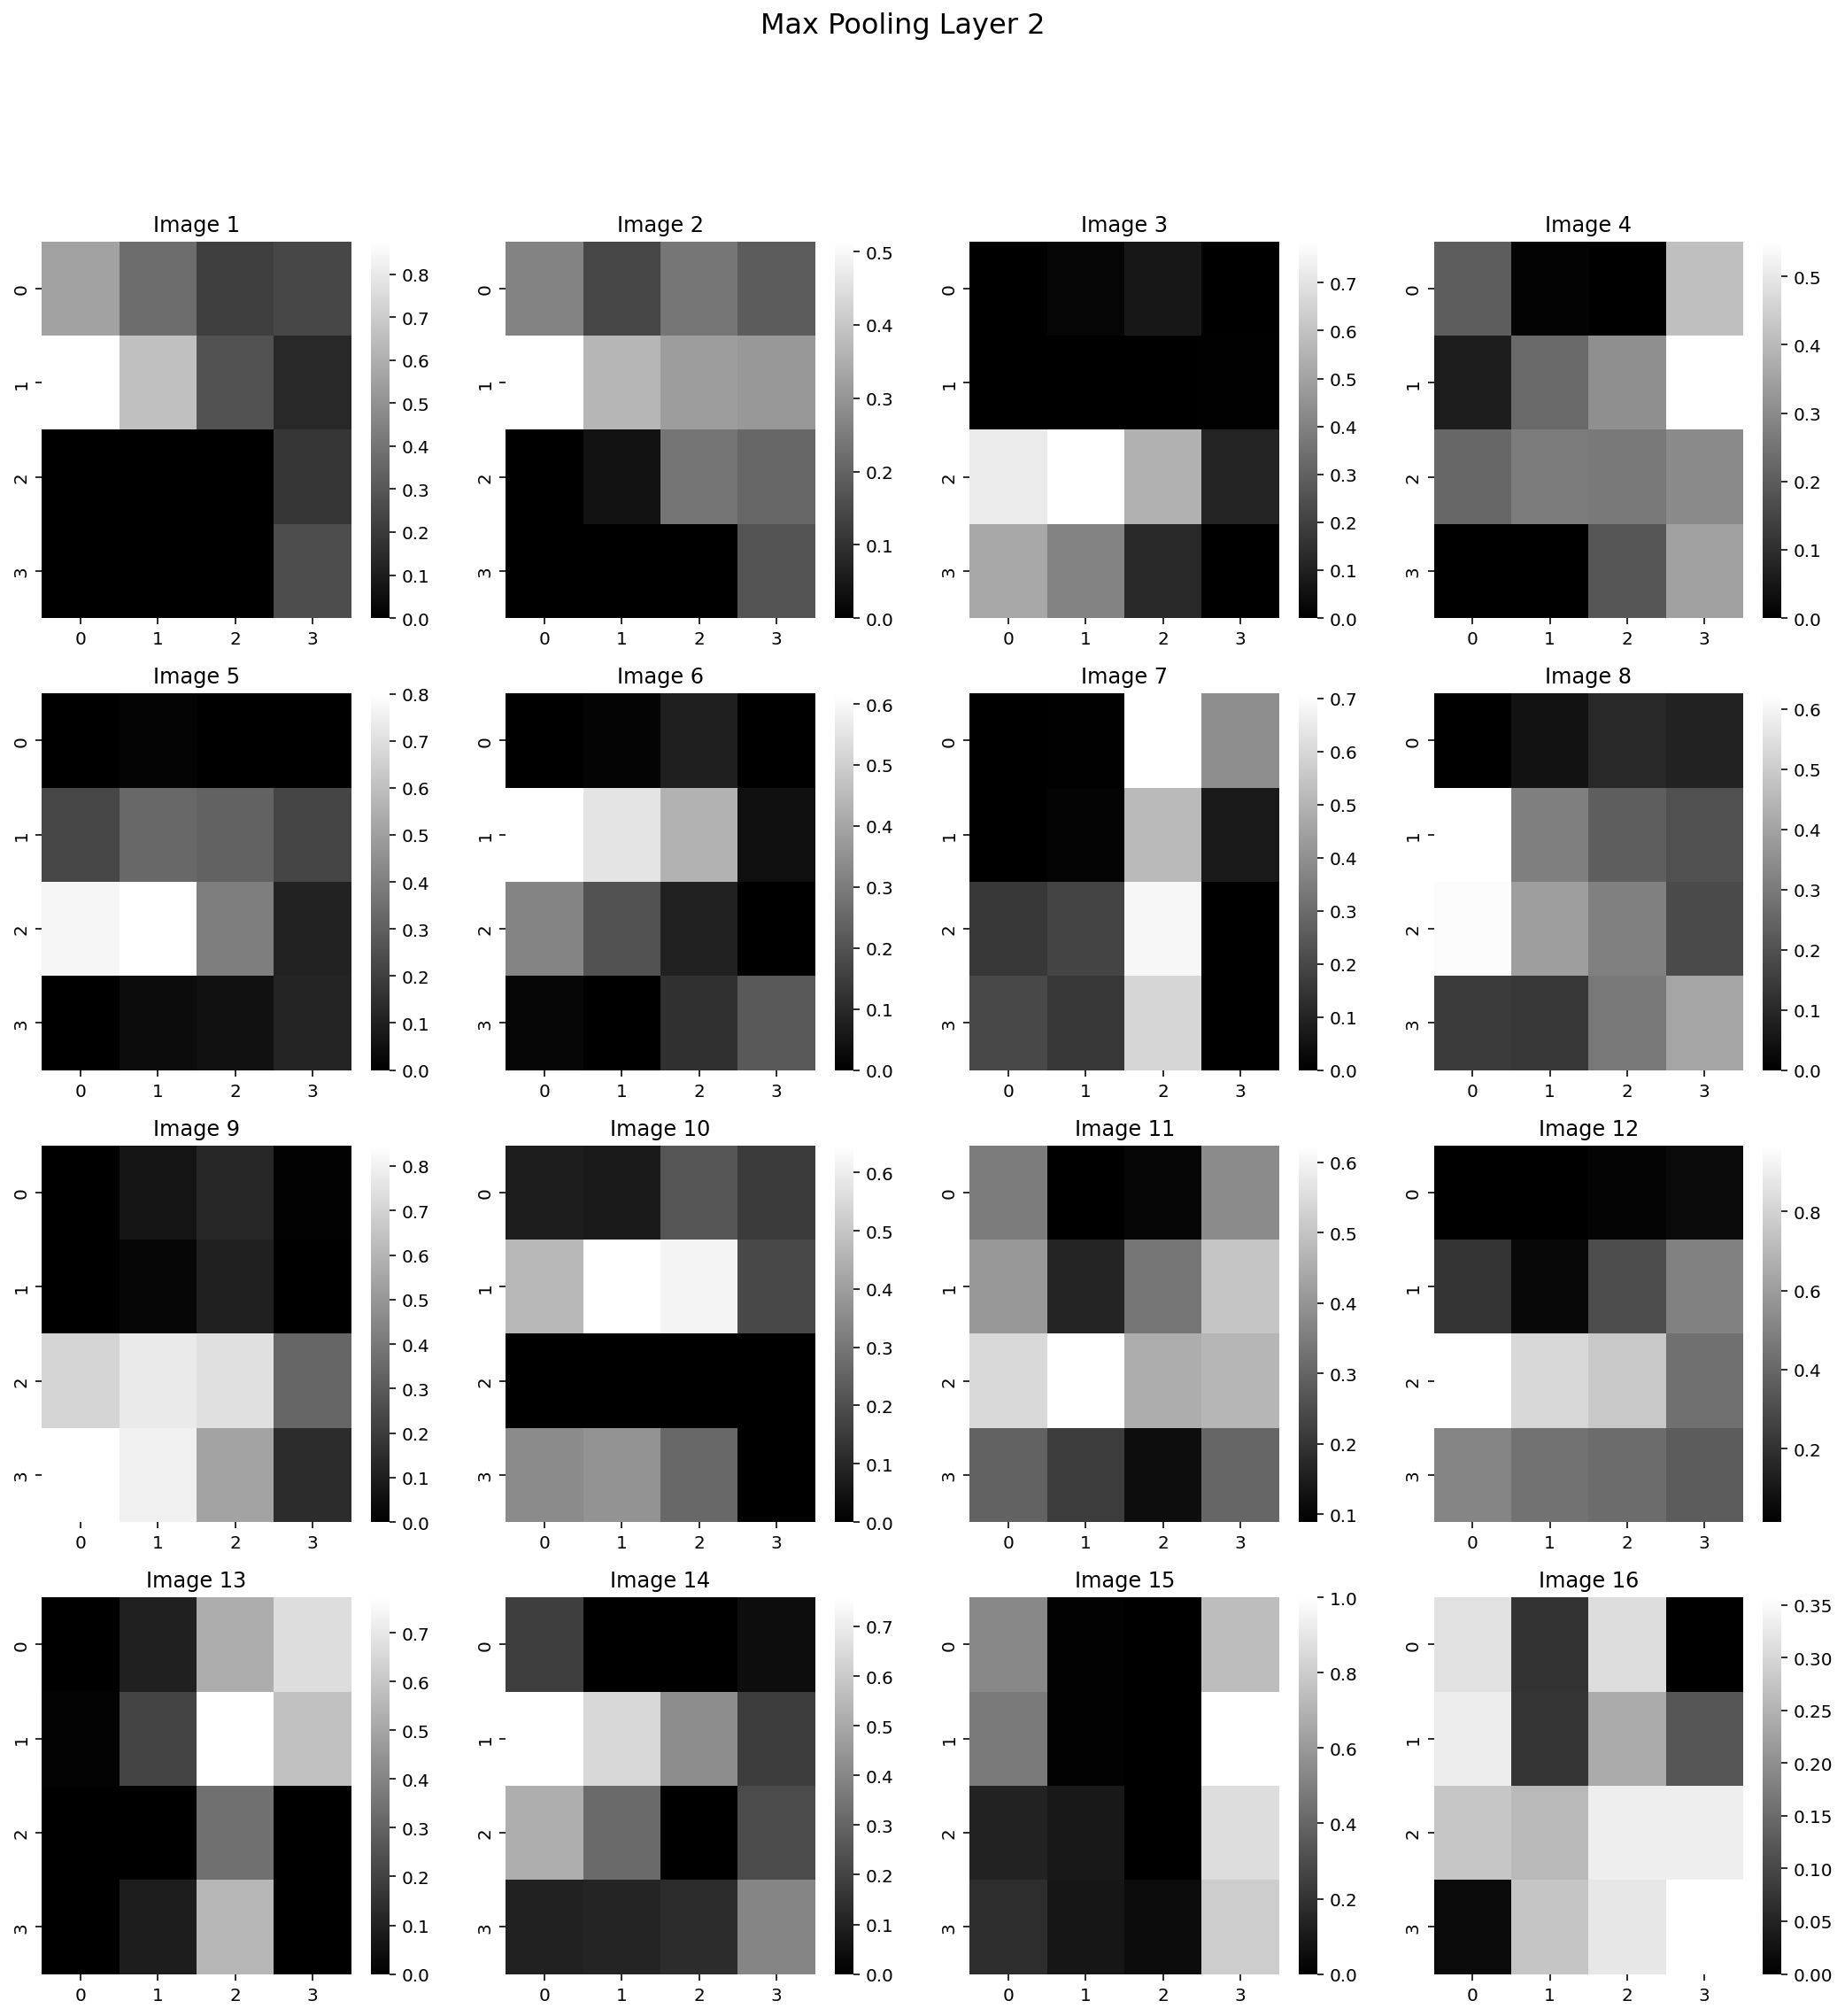

In [47]:
visualize_conv_output(model, train_data[2][0].unsqueeze(0))

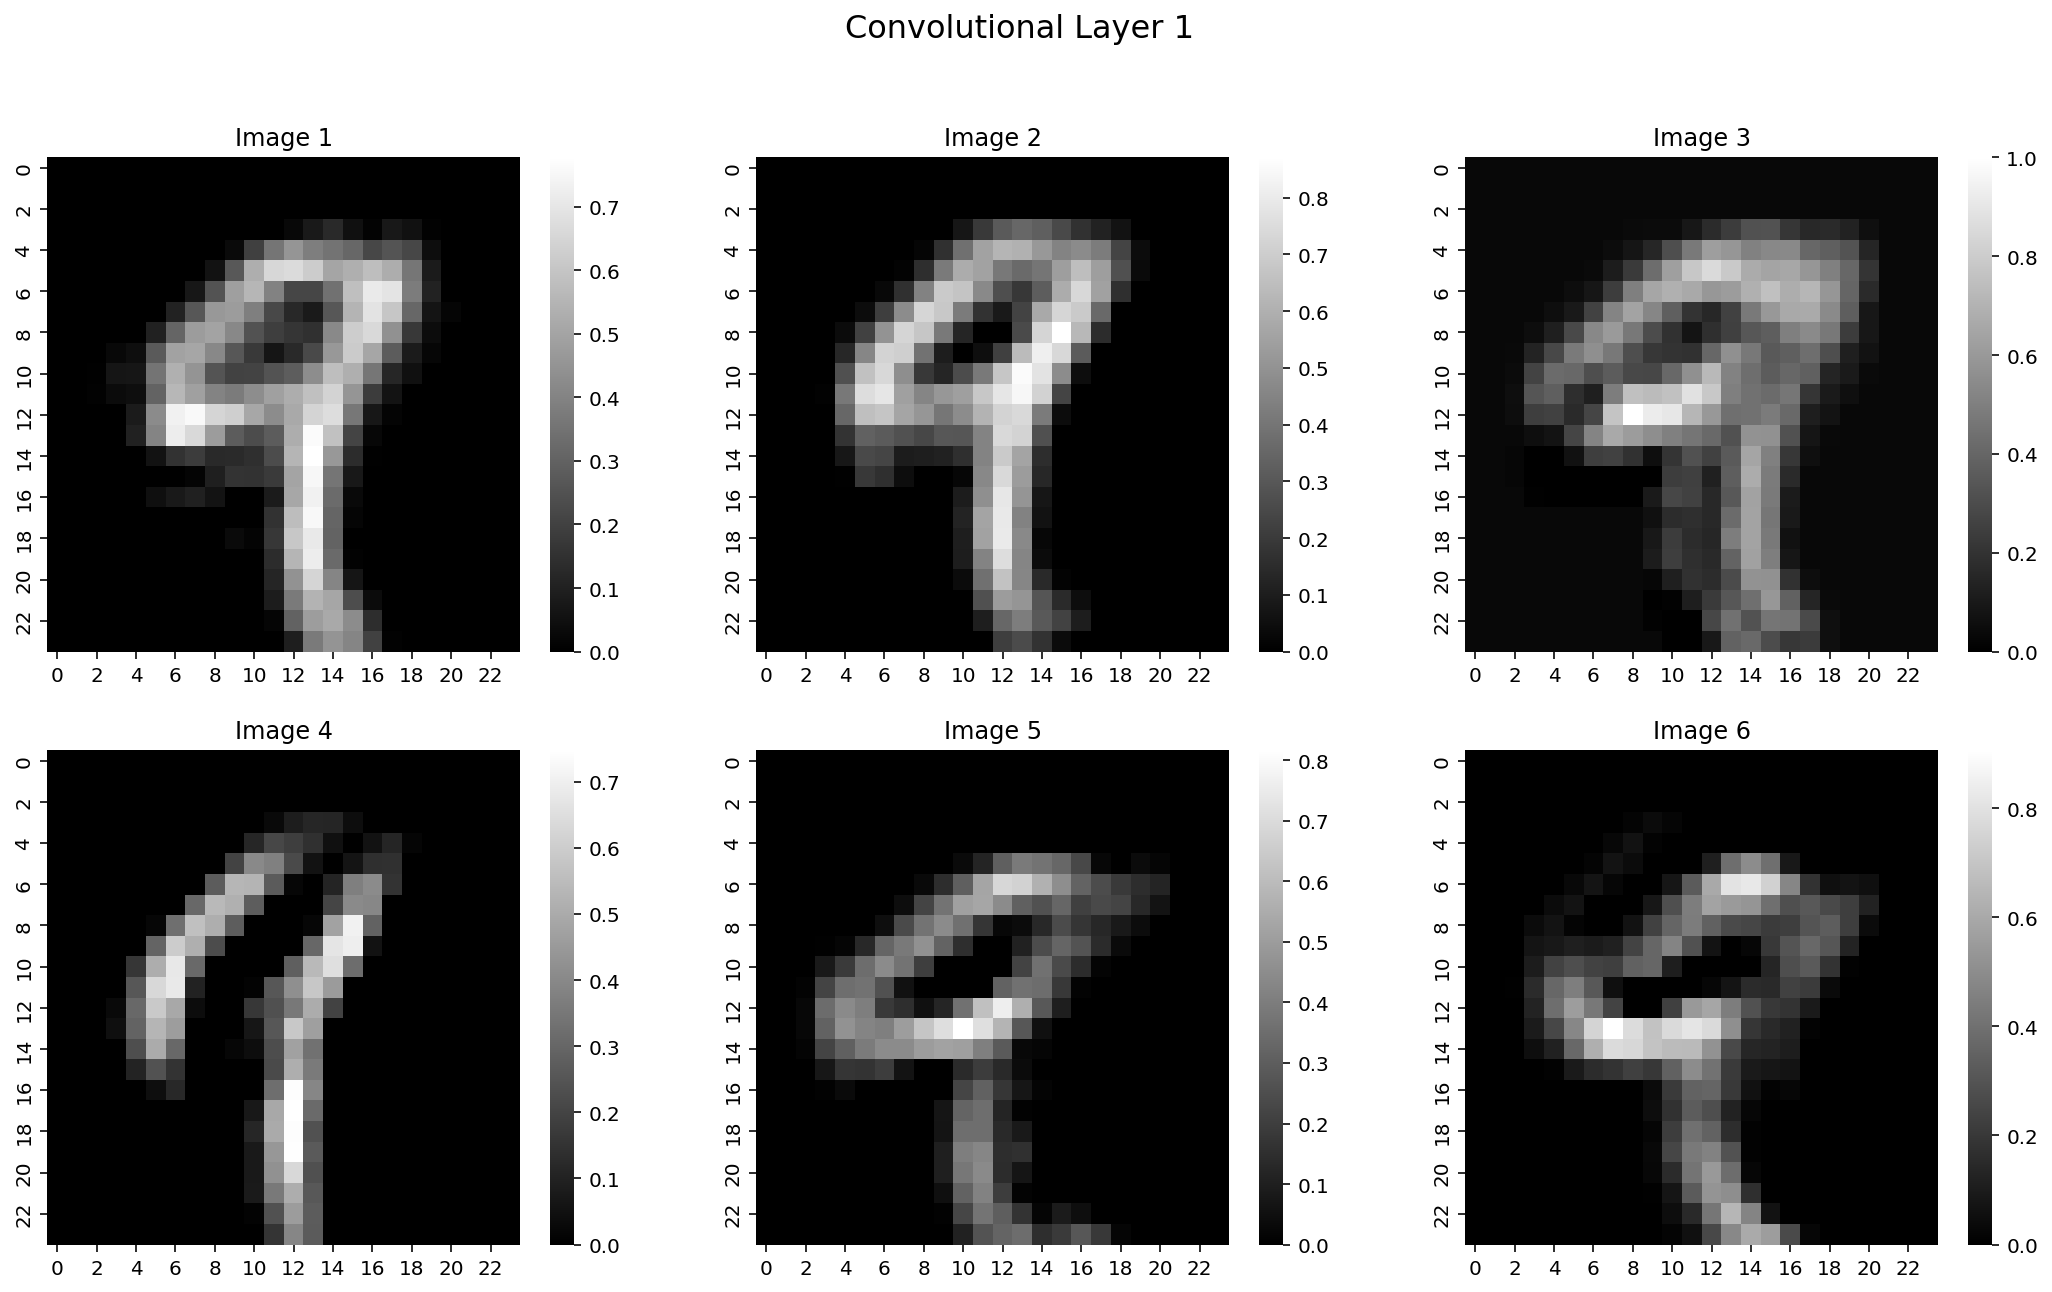

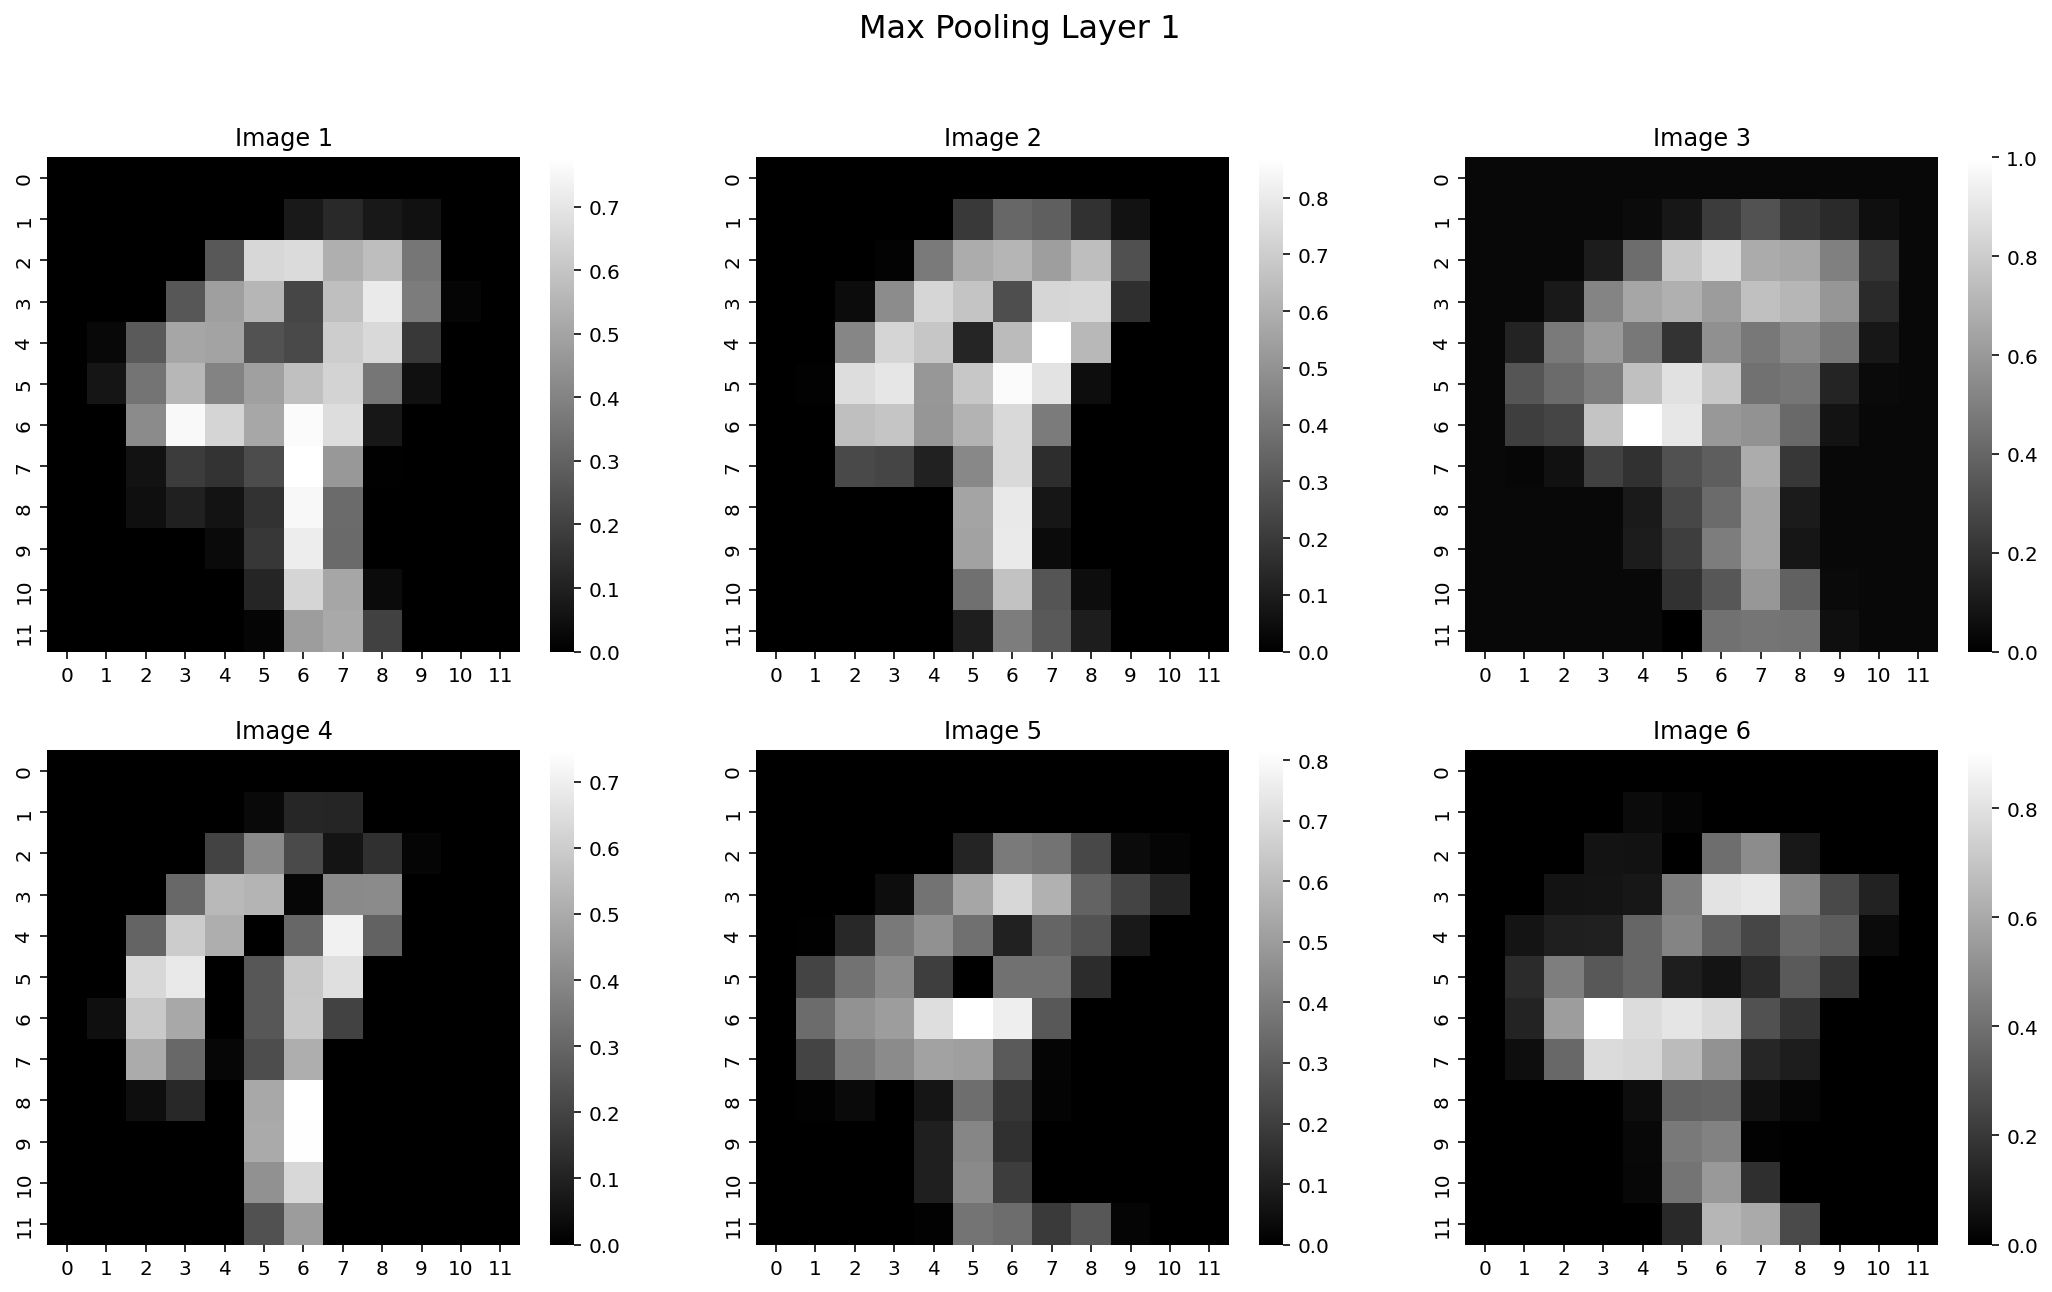

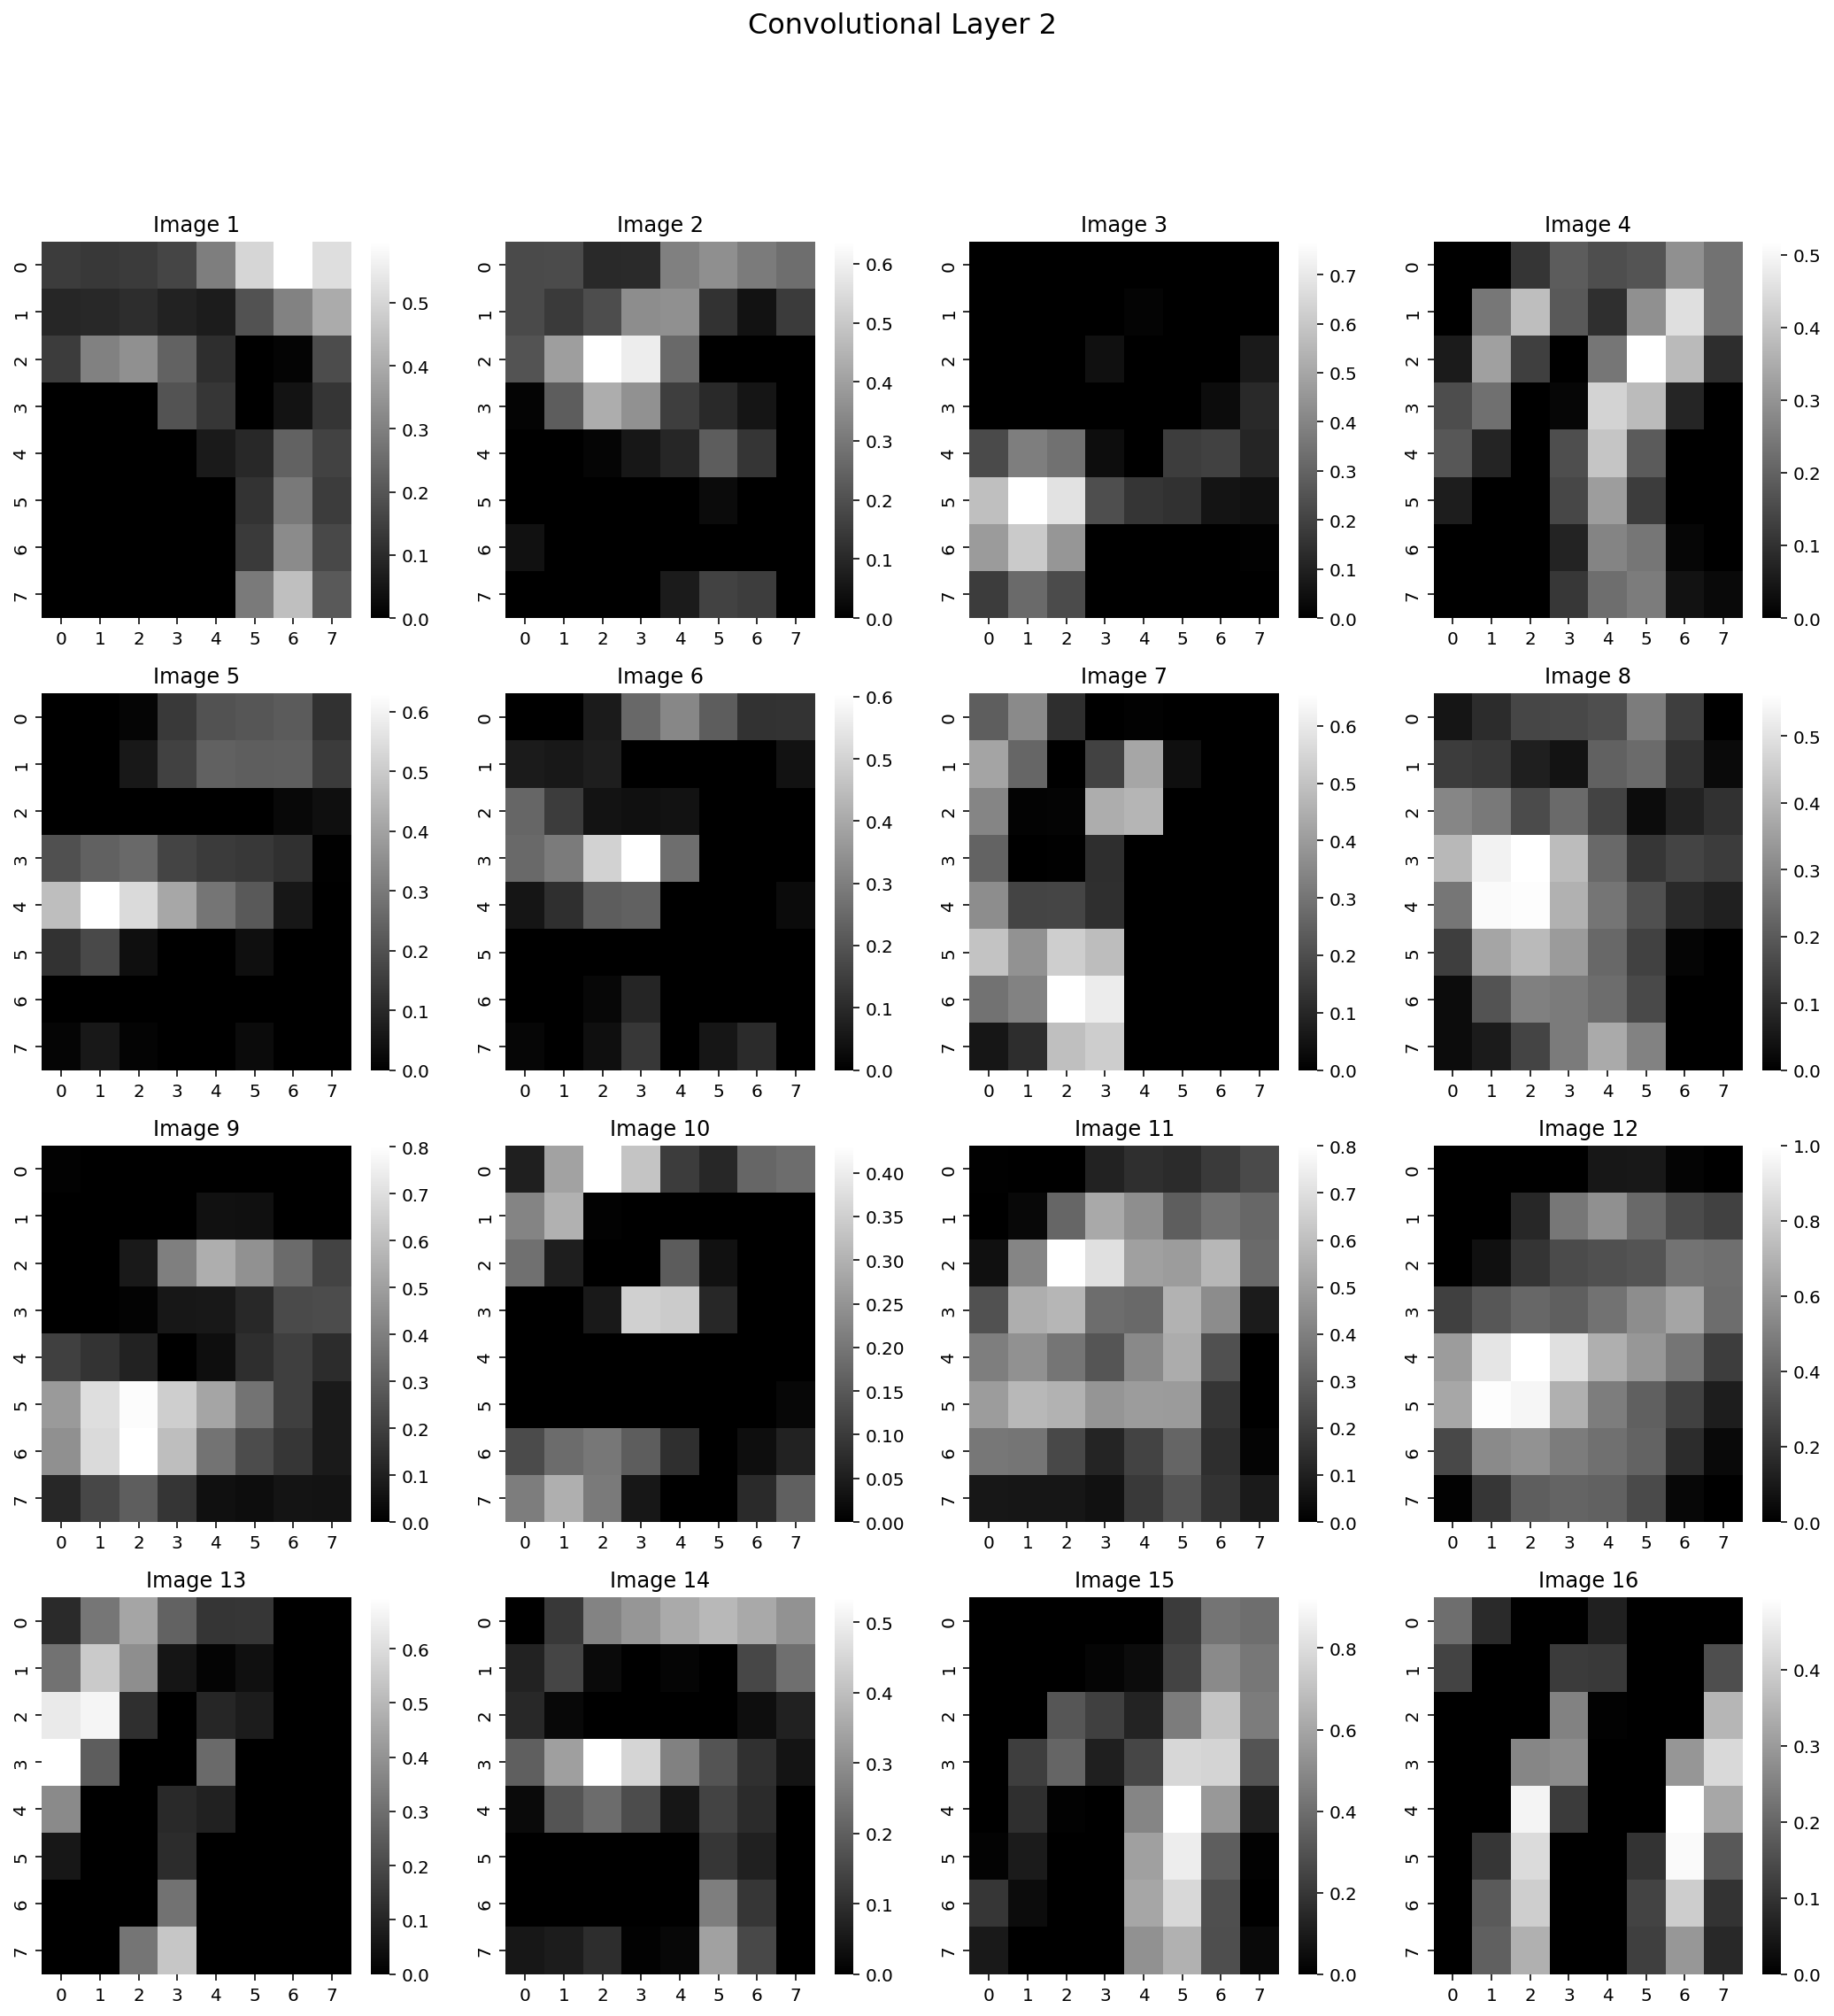

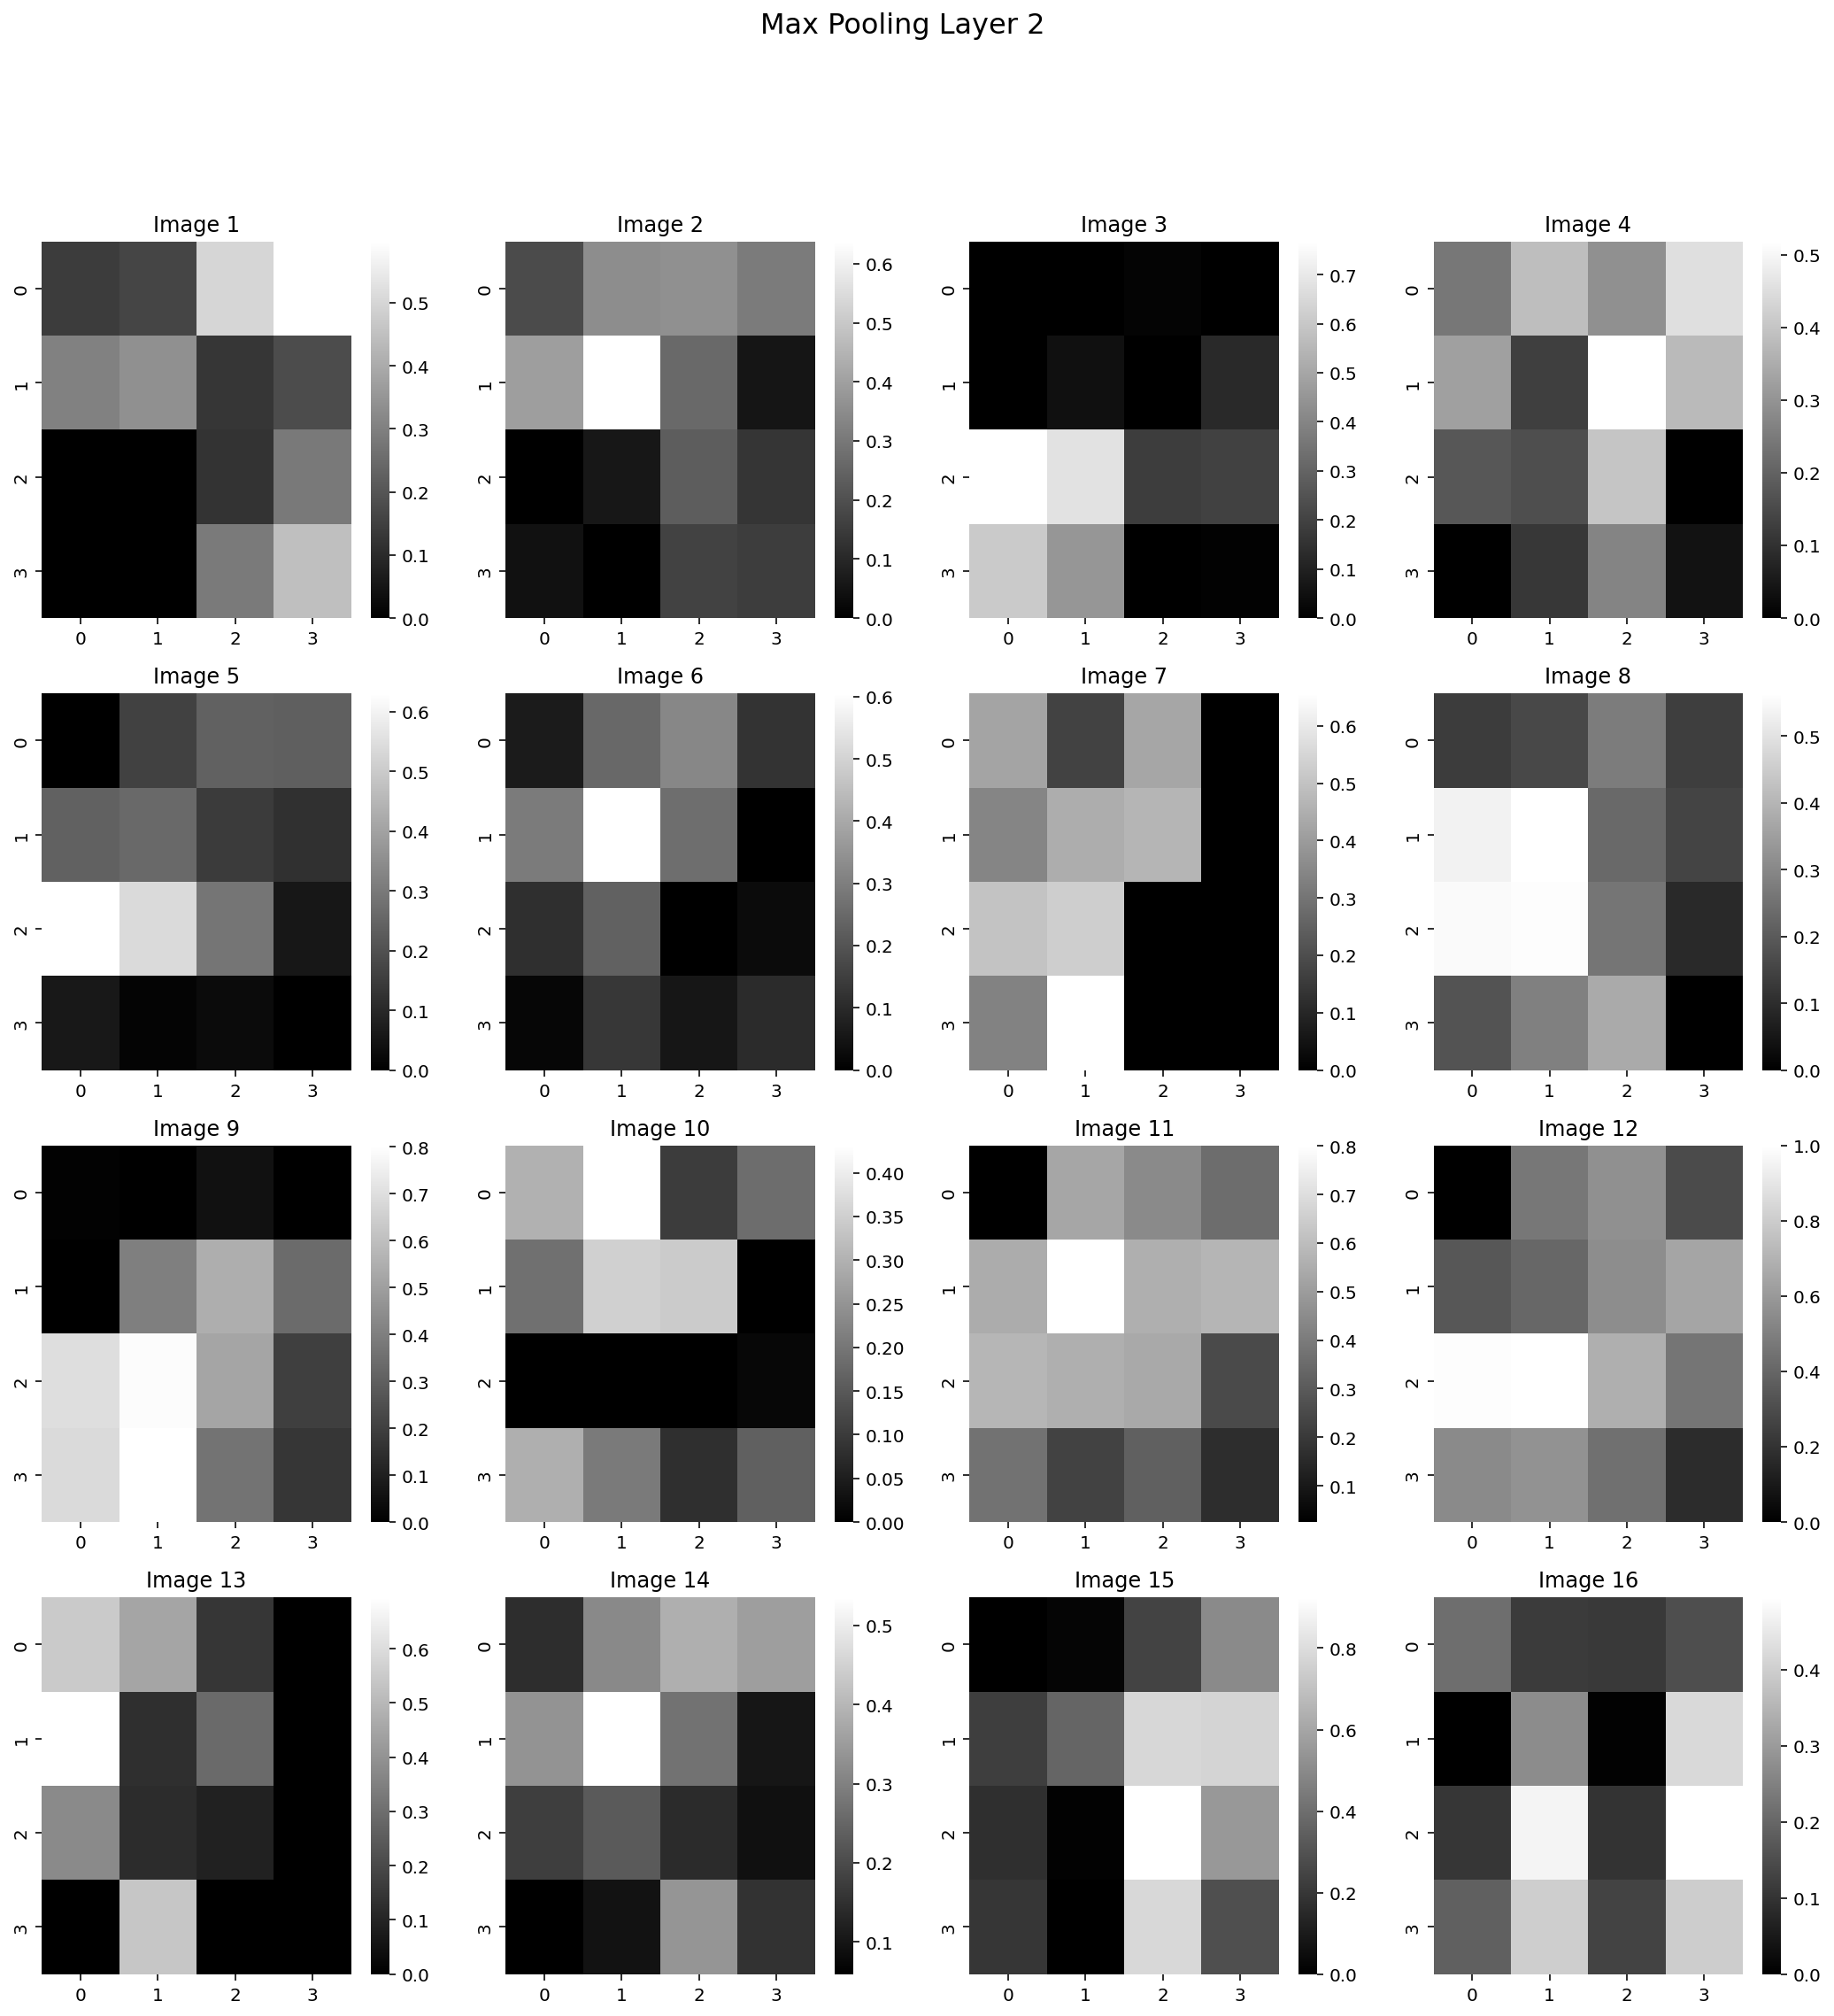

In [49]:
visualize_conv_output(model, train_data[4][0].unsqueeze(0))